## Entrenamiento y evaluación de un modelo de *Machine Learning*:
# Predicción de precios de Alojamientos destinados al alquiler vacacional

##### Importación de librerías

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor


### Importación del DataFrame:

In [2]:
airbnb_listings_extract=pd.read_csv("./airbnb-listings-extract.csv", sep=";", header=0)

#### Documentación del DataFrame

Fuente: [https://www.kaggle.com/datasets/randybarberena/airbnb-open-data-dictionary?resource=download](URL)

In [3]:
df_documentation=pd.read_csv("./Airbnb_open_data_dictionary.csv", sep=";", header=0)

df_documentation=df_documentation.values

for i in range(0,df_documentation.shape[0]):
    print(
        f"\033[1m{df_documentation[i,0]}\033[0m\n"
        f"{df_documentation[i,1]}\n"
    )

ID
Airbnb's unique identifier for the listing

Listing_Url
nan

Scrape_ID
Inside Airbnb ""Scrape"" this was part of

Last_Scraped
UTC. The date and time this listing was ""scraped"".

Name
Name of the listing

Summary
Summary description of the listing

Space
Description of the space for rent

Description
Detailed description of the listing

Experiences_Offered
Description of the experiences offered

Neighborhood_Overview
Host's description of the neighbourhood

Notes
Notes for the listing. In some cities, Airbnb instructs the host to write the legal Permit #, in liue of using the license_number field

Transit
Notes for the listing

Access
Access notes

Interaction
nan

House_Rules
nan

Thumbnail_Url
URL to the Airbnb hosted thumbnail image for the listing

Medium_Url
URL to the Airbnb hosted medium sized image for the listing

Picture_Url
URL to the Airbnb hosted regular sized image for the listing

XL_Picture_Url
URL to the Airbnb hosted XL sized image for the listing

Host_ID
Airbnb

### Exploración básica del DataFrame:

Exploración básica del DataFrame para valorar los parámetros de división de los datos en conjuntos de Train y Test:

In [4]:
print(
    f"El dataset tiene {airbnb_listings_extract.shape[0]} muestras.\n"
    f"La dimensionalidad del dataset es {airbnb_listings_extract.shape[1]}.\n"
    "La variable objetivo (Price) se encuentra en la columna con índice "
    f"{airbnb_listings_extract.columns.get_loc('Price')}.\n\n\n"
    f"{"Col. Index":<15}"
    f"{"Column name":<33}"
    f"{"Type":<12}"
    f"{"N unique":<10}"
    f"{"Value e.g.":<10}\n"
)

for i in range(airbnb_listings_extract.shape[1]):
    print(
        f"{"":<5}"
        f"{str(i):<10}"
        f"{str(airbnb_listings_extract.columns[i]):<33}"
        f"{str(airbnb_listings_extract.iloc[:, i].dtypes):<10}"
        f"{str(airbnb_listings_extract.iloc[:, i].nunique()):<10}"
        f"{str(airbnb_listings_extract.iloc[:, i]
               .sort_values(ascending=False).iloc[0])[0:10]:<20}"
        
    )


El dataset tiene 14780 muestras.
La dimensionalidad del dataset es 89.
La variable objetivo (Price) se encuentra en la columna con índice 56.


Col. Index     Column name                      Type        N unique  Value e.g.

     0         ID                               int64     14780     19109692            
     1         Listing Url                      object    14780     https://ww          
     2         Scrape ID                        int64     38        2017061500          
     3         Last Scraped                     object    37        2017-06-15          
     4         Name                             object    14375     马德里，你的落脚之处          
     5         Summary                          object    13289     ﻿ Hablar d          
     6         Space                            object    10174     혹여나 가족이 오는          
     7         Description                      object    14281     ﻿ Hablar d          
     8         Experiences Offered              object    5   

Analizamos la necesidad de un modelo de carácter temporal. Las columnas que contienen a fechas son:

In [5]:
for i in list(airbnb_listings_extract.columns[[3,22,71,73,74]]):
    print(i)

Last Scraped
Host Since
Calendar last Scraped
First Review
Last Review


Podemos descartar el carácter temporal del modelo dado que:
* La fecha de la consulta de un alojamiento (Last Scraped, Calendar last Scraped) en la web no debería tener implicación en el precio
* No hay razones para que el precio del alojamiento se vea afectado por la fecha de alta del anfitrión (Host Since)
* Las fechas de publicación de las reviews de los huéspedes no deberñian influir en el precio (First Review, Last Review)

### División en Train y Test

División de los datos en un conjunto de Train y uno de Test:

In [6]:
airbnb_train_df,airbnb_test_df = train_test_split(airbnb_listings_extract, test_size = 0.3, shuffle = True, random_state = 0)

Hacemos una copia de airbnb_train_df sin modificar por si lo necesitamos para imputaciones en test.

In [7]:
airbnb_train_df_copy=airbnb_train_df.copy()

### Exploración y preprocesamiento de los datos en profundidad

#### Descarte inicial de columnas por suministrar información que influya en el precio

Analizando los datos del DataFrame, vemos que hay columnas que no aportan información que influya en el precio. Algunas incluso pueden depender del propio precio y no viceversa  (Monsthly y Weekly price).Por ello, procedemos a descartar las siguientes columnas:

In [8]:
to_delete=[
    'ID'
    , 'Listing Url'
    , 'Name'
    , 'Summary'
    , 'Space'
    , 'Description'
    , 'Neighborhood Overview'
    , 'Notes'
    , 'Transit'
    , 'Access'
    , 'Interaction'
    , 'House Rules'
    , 'Thumbnail Url'
    , 'Medium Url'
    , 'Picture Url'
    , 'XL Picture Url'
    , 'Street'
    , 'Monthly Price'
    , 'Weekly Price'
    , 'Calendar Updated'
    , 'Extra People'
    , 'Host ID'
    , 'Host URL'
    , 'Host Name'
    , 'Host Since'
    , 'Host Location'
    , 'Host Neighbourhood'
    , 'Host About'
    , 'Host Acceptance Rate'
    , 'Host Thumbnail Url'
    , 'Host Picture Url'
    , 'Host Verifications'
    , 'Has Availability'
    , 'First Review'
    , 'Last Review'
    , 'License'
    , 'Jurisdiction Names'
    , 'Features'
]

for i in range(len(to_delete)):
    print(to_delete[i])
    
airbnb_train_df=airbnb_train_df.drop(to_delete, axis=1)

ID
Listing Url
Name
Summary
Space
Description
Neighborhood Overview
Notes
Transit
Access
Interaction
House Rules
Thumbnail Url
Medium Url
Picture Url
XL Picture Url
Street
Monthly Price
Weekly Price
Calendar Updated
Extra People
Host ID
Host URL
Host Name
Host Since
Host Location
Host Neighbourhood
Host About
Host Acceptance Rate
Host Thumbnail Url
Host Picture Url
Host Verifications
Has Availability
First Review
Last Review
License
Jurisdiction Names
Features


Algunas de las columnas que hemos conservado pueden aparentar no tener influencia directa en el precio. Sin embargo, las conservamos por el momento, hasta ver si sí pueden ser de influencia en el precio por un algoritmo de visitas de los anuncios y/o frecuencia de alquiler del alojamiento.

#### Exploración de columnas con valores nulos

Valores nulos de cada columna:

In [9]:
print(f"Number of null values per column out of {airbnb_train_df.shape[0]} total samples\n")
nulls_in_columns_ordered=airbnb_train_df.isnull().sum().sort_values(ascending=False)


for i in nulls_in_columns_ordered.index:
        print(
            f"{i:<35}"
            f"{nulls_in_columns_ordered[i]:<10}"
            f"{nulls_in_columns_ordered[i]*100/airbnb_train_df.shape[0]:.2f}%"
        )


Number of null values per column out of 10346 total samples

Square Feet                        9936      96.04%
Security Deposit                   5899      57.02%
Cleaning Fee                       4222      40.81%
Neighbourhood                      3640      35.18%
Review Scores Value                2379      22.99%
Review Scores Location             2377      22.98%
Review Scores Checkin              2375      22.96%
Review Scores Accuracy             2370      22.91%
Review Scores Cleanliness          2366      22.87%
Review Scores Communication        2366      22.87%
Review Scores Rating               2351      22.72%
Reviews per Month                  2246      21.71%
Host Response Time                 1330      12.86%
Host Response Rate                 1330      12.86%
Neighbourhood Group Cleansed       701       6.78%
Zipcode                            347       3.35%
Amenities                          131       1.27%
State                              106       1.02%
Market 

##### Square Feet

Decidimos eliminar Square Feet, con tan pocos valores no podemos obtener información suficiente.Imputar valores sería una minupulación excesiva de los datos. Además, seguramente no tenga mucha influencia en alquiler vacacional.

In [10]:
airbnb_train_df=airbnb_train_df.drop('Square Feet', axis=1)

##### Security Deposit

Decidimos eliminar Security Deposit, ya que imputar valores sería una minupulación excesiva de los datos. Además, seguramente su influencia en el precio sea indirecta.

In [11]:
airbnb_train_df=airbnb_train_df.drop('Security Deposit', axis=1)

##### Cleaning Fee

Estudiaremos más a fondo su relación con Price:

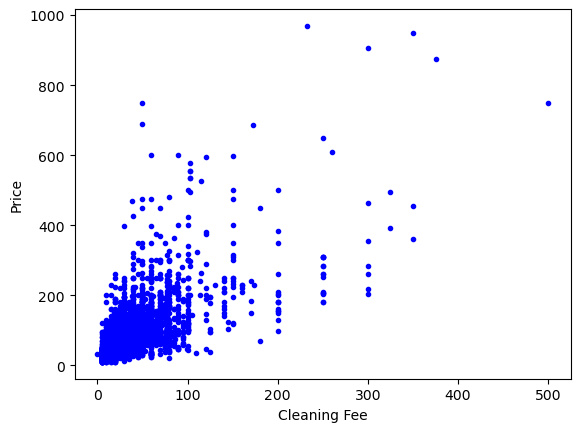

In [12]:
plt.plot(airbnb_train_df['Cleaning Fee'],airbnb_train_df['Price'],'b.',label='$y_i$')
plt.xlabel('Cleaning Fee')
plt.ylabel('Price')
plt.show()

Vemos que existe una relación entre Cleaning Fee y price, por lo que decidimos imputar la moda antes que quitar la columma.

In [13]:
airbnb_train_df['Cleaning Fee'].fillna(airbnb_train_df['Cleaning Fee'].mode()[0], inplace=True)

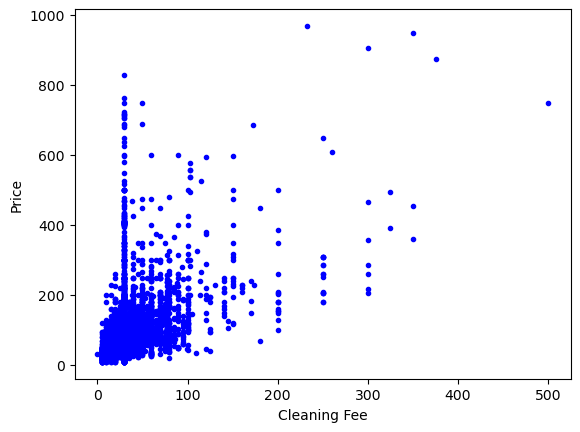

In [14]:
plt.plot(airbnb_train_df['Cleaning Fee'],airbnb_train_df['Price'],'b.',label='$y_i$')
plt.xlabel('Cleaning Fee')
plt.ylabel('Price')
plt.show()

##### Neighbourhood, Zipcode, Neighbourhood Group Cleansed

Dado que tenemos otra columna sin nulos que proporciona información sobre lo mismo y no tiene valores nulos (Neighbourhood Cleansed), las eliminamos

In [15]:
airbnb_train_df=airbnb_train_df.drop('Neighbourhood', axis=1)

In [16]:
airbnb_train_df=airbnb_train_df.drop('Neighbourhood Group Cleansed', axis=1)

In [17]:
airbnb_train_df=airbnb_train_df.drop('Zipcode', axis=1)

##### Review Scores

Imputamos la moda para las columnas Relacionadas con Review Scores. Dado que, además, son valores que involucran cierta subjetividad el error de imputación no afectará tanto.

In [18]:
airbnb_train_df['Review Scores Value'].fillna(airbnb_train_df['Review Scores Value'].mode()[0], inplace=True)
airbnb_train_df['Review Scores Location'].fillna(airbnb_train_df['Review Scores Location'].mode()[0], inplace=True)
airbnb_train_df['Review Scores Checkin'].fillna(airbnb_train_df['Review Scores Checkin'].mode()[0], inplace=True)
airbnb_train_df['Review Scores Accuracy'].fillna(airbnb_train_df['Review Scores Accuracy'].mode()[0], inplace=True)
airbnb_train_df['Review Scores Communication'].fillna(airbnb_train_df['Review Scores Communication'].mode()[0], inplace=True)
airbnb_train_df['Review Scores Cleanliness'].fillna(airbnb_train_df['Review Scores Cleanliness'].mode()[0], inplace=True)
airbnb_train_df['Review Scores Rating'].fillna(airbnb_train_df['Review Scores Rating'].mode()[0], inplace=True)

##### Reviews per Month

Imputamos la moda para la columna Reviews per month:

In [19]:
airbnb_train_df['Reviews per Month'].fillna(airbnb_train_df['Reviews per Month'].mode()[0], inplace=True)

##### Host Response Rate

Imputamos la moda para la columna Host Response Rate

In [20]:
airbnb_train_df['Host Response Rate'].fillna(airbnb_train_df['Host Response Rate'].mode()[0], inplace=True)

##### Host Response Time

In [21]:
airbnb_train_df['Host Response Time'].drop_duplicates()

4706        within an hour
1666                   NaN
4358    within a few hours
5948          within a day
1729    a few days or more
Name: Host Response Time, dtype: object

Categorizamos Host Response Time a una equivalencia estimada promedio de horas de los tiempos a los que hace referencia cada categoría con valores no nulos. Esta catgorización es provisional para poder representar los datos.

In [22]:
airbnb_train_df.loc[airbnb_train_df['Host Response Time'] == 'within an hour', 'Host Response Time'] = 1
airbnb_train_df.loc[airbnb_train_df['Host Response Time'] == 'within a few hours', 'Host Response Time'] = 15
airbnb_train_df.loc[airbnb_train_df['Host Response Time'] == 'within a day', 'Host Response Time'] = 24
airbnb_train_df.loc[airbnb_train_df['Host Response Time'] == 'a few days or more', 'Host Response Time'] = 72

In [23]:
airbnb_train_df['Host Response Time'].drop_duplicates()

4706      1
1666    NaN
4358     15
5948     24
1729     72
Name: Host Response Time, dtype: object

In [24]:
airbnb_train_df['Host Response Time'].fillna(airbnb_train_df['Host Response Time'].mode()[0], inplace=True)

##### Amenities

Comprobamos si el número de amenities influye en el precio

In [25]:
airbnb_train_df['Amenities'].drop_duplicates()

4706     TV,Internet,Wireless Internet,Air conditioning...
6422     Internet,Wireless Internet,Air conditioning,Ki...
4339     TV,Wireless Internet,Kitchen,Smoking allowed,E...
1666     TV,Wireless Internet,Kitchen,Smoking allowed,F...
4578     TV,Wireless Internet,Kitchen,Smoking allowed,H...
                               ...                        
9225     TV,Internet,Wireless Internet,Air conditioning...
14019    TV,Internet,Wireless Internet,Kitchen,Smoking ...
13123    TV,Internet,Wireless Internet,Kitchen,Breakfas...
10799    TV,Cable TV,Wireless Internet,Kitchen,Buzzer/w...
2732     TV,Internet,Wireless Internet,Kitchen,Doorman,...
Name: Amenities, Length: 8915, dtype: object

Comprobamos si merece la pena extraer alguna de las amenities como columna del dataframe. Creamos un dataframe con todas las amenities y valor 0 si el alojamiento no dispone de ella, o 1 si sí dispone de ella. rellenamos los nulos con la moda de la propia Amenity.

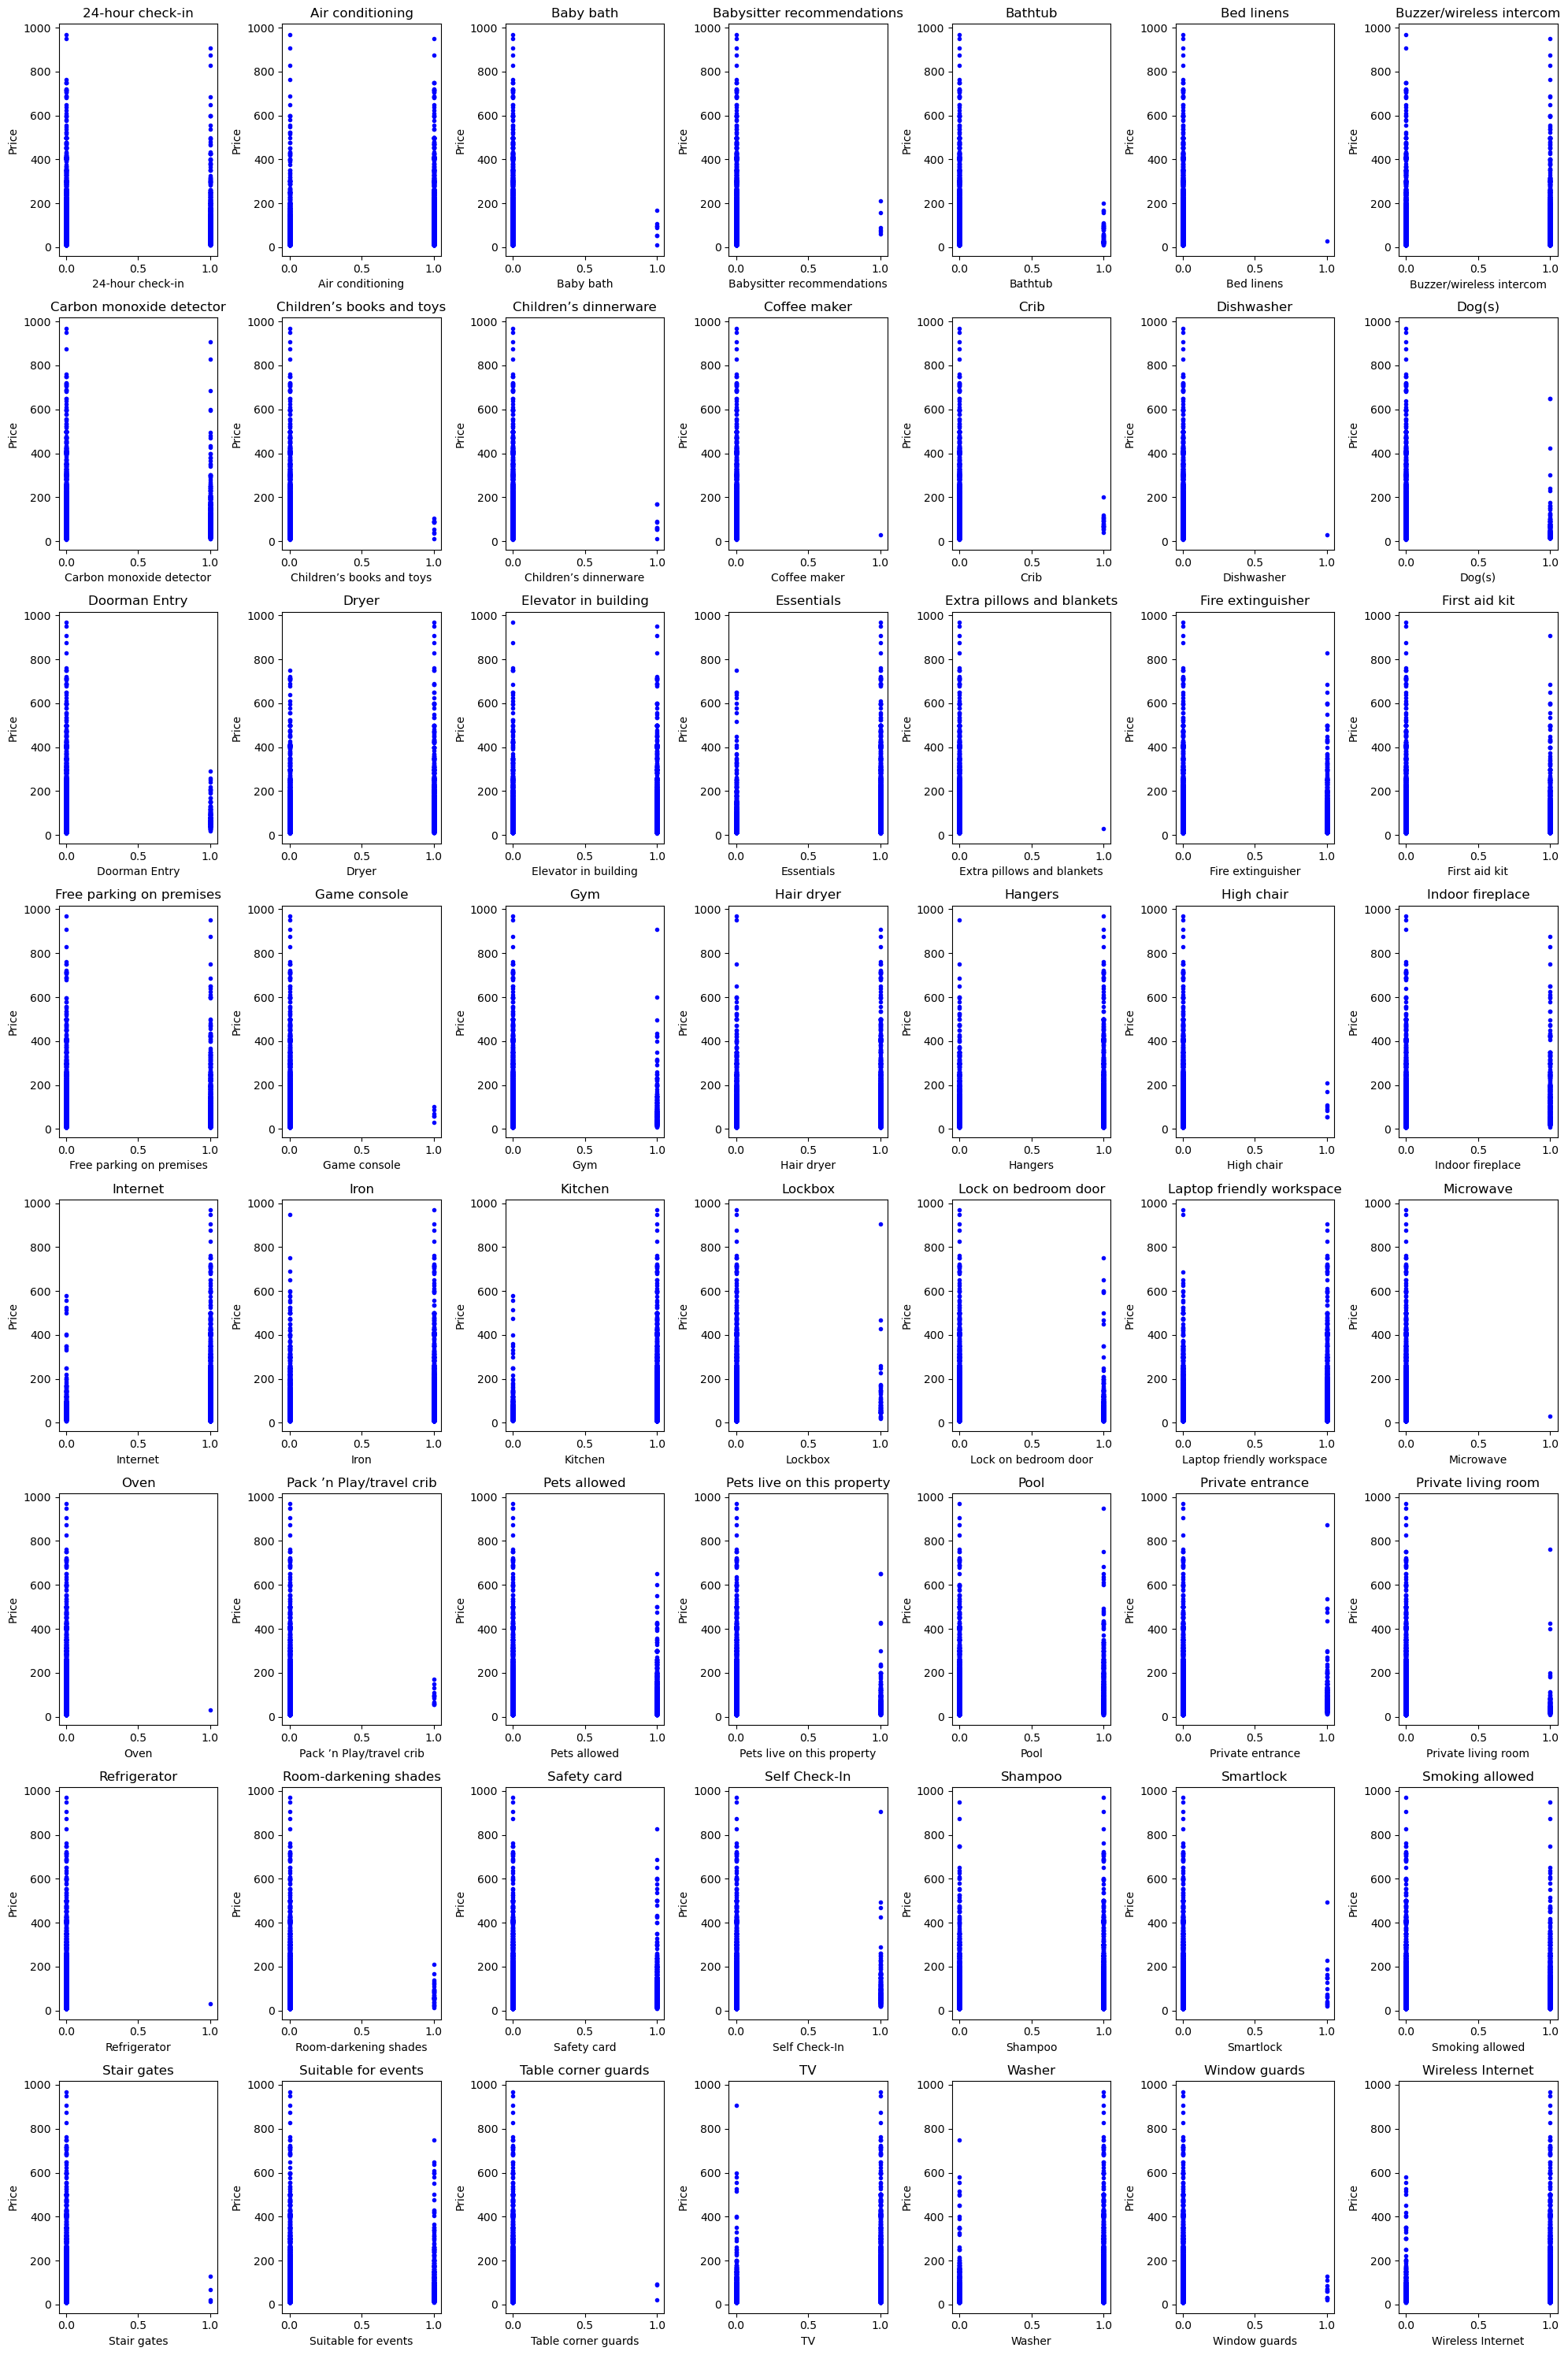

In [26]:
amenities_df = airbnb_train_df[['Amenities','Price']].copy()

amenities_list = [
    "24-hour check-in", "Air conditioning", "Baby bath", "Babysitter recommendations", 
    "Bathtub", "Bed linens", "Buzzer/wireless intercom", "Carbon monoxide detector", 
    "Children’s books and toys", "Children’s dinnerware", "Coffee maker", 
    "Crib", "Dishwasher", "Dog(s)", "Doorman Entry", "Dryer", "Elevator in building", 
    "Essentials", "Extra pillows and blankets", "Fire extinguisher", "First aid kit", 
    "Free parking on premises", "Game console", "Gym", "Hair dryer", "Hangers", 
    "High chair", "Indoor fireplace", "Internet", "Iron", "Kitchen", "Lockbox", 
    "Lock on bedroom door", "Laptop friendly workspace", "Microwave", 
    "Oven", "Pack ’n Play/travel crib", "Pets allowed", "Pets live on this property", 
    "Pool", "Private entrance", "Private living room", "Refrigerator", "Room-darkening shades", 
    "Safety card", "Self Check-In", "Shampoo", "Smartlock", "Smoking allowed", "Stair gates", 
    "Suitable for events", "Table corner guards", "TV", "Washer", "Window guards", 
    "Wireless Internet"
]

amenities_df['Amenities'] = amenities_df['Amenities'].fillna('to_be_imputed').astype(str)

for amenity in amenities_list:
    amenities_df[amenity] = amenities_df['Amenities'].apply(lambda x: 'to_be_imputed' if x == 'to_be_imputed' else amenity in x)


for column in amenities_list:
    moda = amenities_df[column][amenities_df[column] != 'to_be_imputed'].mode()
    if not moda.empty:  # Si se encuentra la moda
        moda_value = moda[0]
        amenities_df[column] = amenities_df[column].replace('to_be_imputed', moda_value)

for column in amenities_list:
    amenities_df[column] = amenities_df[column].astype(int)

fig, axes = plt.subplots(8, 7, figsize=(20, 30))  
axes = axes.flatten() 


for i, column in enumerate(amenities_list):
    ax = axes[i] 
    ax.plot(amenities_df[column], amenities_df['Price'], 'b.')
    ax.set_xlabel(column)
    ax.set_ylabel('Price')
    ax.set_title(column)

plt.tight_layout()

plt.show()

No observamos una alta influencia de ninguna de las amenities (ninguna muestra precios altos en el caso de disponibilidad de la amenity (1) y precios bajos en caso contrario), por lo que descartamos crear dichas características en nuestro dataframe.
Comprobamos si la cantidad de amenities puede ser relevante.

In [27]:
airbnb_train_df.loc[airbnb_train_df['Amenities'].notna(), 'Amenities']= airbnb_train_df['Amenities'].str.count(',') + 1


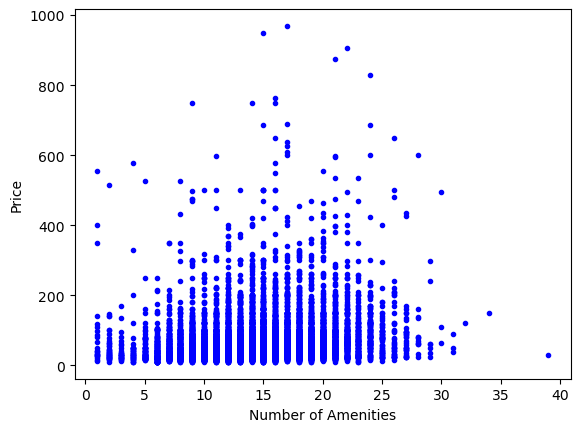

In [28]:
plt.plot(airbnb_train_df['Amenities'],airbnb_train_df['Price'],'b.')
plt.xlabel('Number of Amenities')
plt.ylabel('Price')
plt.show()

Vemos según aumentan las amenities, el precio sube y después baja. La bajada de precio no tiene una relación lógica con el número de amenities, por lo que probablemente podamos deducir que el número de amenities no tiene influencia en el precio. Descartandos, por tanto, dicha característica.

In [29]:
airbnb_train_df=airbnb_train_df.drop('Amenities', axis=1)

##### State, Market, Smart Location, City

In [30]:
airbnb_train_df[['State', 'Market', 'Smart Location', 'City']].drop_duplicates()

,State,Market,Smart Location,City
4706,Community of Madrid,Madrid,"Madrid, Spain",Madrid
6422,Comunidad de Madrid,Madrid,"Madrid, Spain",Madrid
3386,Île-de-France,Paris,"Paris, France",Paris
8102,Madrid,Madrid,"Madrid, Spain",Madrid
756,Catalunya,Barcelona,"Barcelona, Spain",Barcelona
...,...,...,...,...
3751,Illes Balears,Mallorca Island,"Alaró, Spain",Alaró
6854,CA,Los Angeles,"San Fernando, CA",San Fernando
5374,Kowloon,Hong Kong,"Tsim Sha Tsui, Hong Kong",Tsim Sha Tsui
13160,CA,Los Angeles,"Beverly Hills, CA",Beverly Hills


Vemos que las columnas State, Market, Smart Location y City proporionan datos similares. Veamos a continuación cuáles tienen datos más completos:

A simple vista City nos proporciona un dato de más calidad (es el municipio, mientras que las otras columnas no aportan un nivel de ubicación contreto. Vemos cuántos nulos hay en cada columna:

In [31]:
airbnb_train_df[['State', 'Market', 'Smart Location', 'City']].isnull().sum()

State             106
Market             39
Smart Location      0
City                4
dtype: int64

Estableceremos ya el procedimiento de imputación de valores nulos de City tanto para train ahora como para test:
Si city es nulo:
* Si Market de ese mismo registro no es nulo y contiene el valor de una ciudad, imputamos market. En caso contrario:
    * Si State de ese mismo registro no es nulo y contiene el valor de una ciudad, imputamos State. En caso contrario:
        * Si State de ese mismo registro no es nulo y contiene el valor de una ciudad, imputamos State (solo la ciudad, sin el pais). En caso contrario:
            * Si State contiene el nombre del país pero no la ciudad, importamos la city que sea la moda en los datos de **train** para la columna Country Code con ese valor de País. Si State no contiene ni valor de país ni de ciudad:
                * Importamos la moda de city de **train**

In [32]:
airbnb_train_df.loc[airbnb_train_df['City'].isnull(), ['City','Smart Location','State', 'Market']]

,City,Smart Location,State,Market
14196,NaN,"ES, Spain",NaN,Madrid
14620,NaN,"Madrid, Spain",Madrid,Madrid
5776,NaN,"ES, Spain",NaN,Madrid
10878,NaN,"Madrid, Spain",Madrid,Madrid


Procedemos a imputar los valores de City a partir de los de Market:


In [33]:
airbnb_train_df.loc[airbnb_train_df['City'].isnull(), 'City'] = airbnb_train_df.loc[airbnb_train_df['City'].isnull(), 'Market']


Borramos las columnas 'Smart Location','State', 'Market':

In [34]:
airbnb_train_df=airbnb_train_df.drop('Smart Location', axis=1)

In [35]:
airbnb_train_df=airbnb_train_df.drop('State', axis=1)

In [36]:
airbnb_train_df=airbnb_train_df.drop('Market', axis=1)

##### Bathrooms

Imputamos la moda para la columna Bathrooms:

In [37]:
airbnb_train_df['Bathrooms'].fillna(airbnb_train_df['Bathrooms'].mode()[0], inplace=True)

##### Beds y bedrooms

Imputamos la moda para la columna Bedrooms:

In [38]:
airbnb_train_df.loc[airbnb_train_df['Beds'].isnull(), ['Beds', 'Bedrooms']]

,Beds,Bedrooms
11565,NaN,NaN
10635,NaN,3.0
1213,NaN,1.0
263,NaN,NaN
4846,NaN,1.0
5987,NaN,NaN
13388,NaN,1.0
11295,NaN,1.0
10313,NaN,1.0
8012,NaN,1.0


In [39]:
airbnb_train_df['Bedrooms'].fillna(airbnb_train_df['Bedrooms'].mode()[0], inplace=True)

Imputamos en los nulos de Beds el valor promedio de número de camas por habitación multiplicado por el valor de la número de habitaciones 

In [40]:
mean_beds_per_bedroom = \
    airbnb_train_df['Beds'].sum()/airbnb_train_df.loc[airbnb_train_df['Beds'].notna(), ['Beds', 'Bedrooms']]['Bedrooms'].sum()

airbnb_train_df['Beds'].fillna(airbnb_train_df['Bedrooms'] * mean_beds_per_bedroom.round(), inplace=True)

##### Price

Eliminamos los 14 registros para los cuales no disponemos de información de la variable objetivo:

In [41]:
airbnb_train_df = airbnb_train_df.dropna(subset=['Price'])


##### Host Listing count

In [42]:
airbnb_train_df[['Calculated host listings count', 'Host Total Listings Count', 'Host Listings Count']].drop_duplicates()

,Calculated host listings count,Host Total Listings Count,Host Listings Count
4706,40.0,40.0,40.0
6422,1.0,1.0,1.0
4339,3.0,3.0,3.0
4578,3.0,4.0,4.0
11565,4.0,4.0,4.0
...,...,...,...
6212,2.0,16.0,16.0
3727,1.0,17.0,17.0
11424,1.0,21.0,21.0
11095,3.0,12.0,12.0


Dado que 'Host Total Listings Count' y 'Host Listings Count' proporcionan la misma información eliminamos uno de ellos

In [43]:
airbnb_train_df=airbnb_train_df.drop('Host Total Listings Count', axis=1)

Importamos la moda en Calculated host listings count y Host Listings Count

In [44]:
airbnb_train_df['Calculated host listings count'].fillna(airbnb_train_df['Calculated host listings count'].mode()[0], inplace=True)

In [45]:
airbnb_train_df['Host Listings Count'].fillna(airbnb_train_df['Host Listings Count'].mode()[0], inplace=True)

##### Country

Estudiamos la relación entre las columnas que hacen relación al país: Country y Country Code

In [46]:
airbnb_train_df[['Country', 'Country Code']].drop_duplicates()

,Country,Country Code
4706,Spain,ES
3386,France,FR
4413,Canada,CA
10913,Germany,DE
9691,Australia,AU
7860,United Kingdom,GB
11747,Belgium,BE
11426,United States,US
9130,Ireland,IE
14307,Italy,IT


In [47]:
airbnb_train_df.loc[airbnb_train_df['Country Code']=='It',['Country', 'Country Code','City']]

,Country,Country Code,City
151,NaN,It,Salerno


Vemos que todos los valores únicos de país tienen un valor único de código de país.
Solo hay una muestra que no tiene un valor de Country tienen un Country Code = 'It'. Teniendo en cuenta otros datos de dicha muestra hacen referencia a Italia, probablemante sea un error tipográfico, lo corregiremos convirtiendo el código a mayúsculas.

In [48]:
airbnb_train_df.loc[airbnb_train_df['Country Code'] == 'It', 'Country Code']= \
airbnb_train_df.loc[airbnb_train_df['Country Code'] == 'It', 'Country Code'] \
        .apply(lambda x: x.upper())

Borramos la columna Country:

In [49]:
airbnb_train_df=airbnb_train_df.drop('Country', axis=1)

Tras este primer procesado, ya no tenemos nulos en nuestros datos de train.

In [50]:
print(f"Number of null values per column out of {airbnb_train_df.shape[0]} total samples\n")
nulls_in_columns_ordered=airbnb_train_df.isnull().sum().sort_values(ascending=False)


for i in nulls_in_columns_ordered.index:
        print(
            f"{i:<35}"
            f"{nulls_in_columns_ordered[i]:<10}"
            f"{nulls_in_columns_ordered[i]*100/airbnb_train_df.shape[0]:.2f}%"
        )


Number of null values per column out of 10332 total samples

Scrape ID                          0         0.00%
Last Scraped                       0         0.00%
Maximum Nights                     0         0.00%
Availability 30                    0         0.00%
Availability 60                    0         0.00%
Availability 90                    0         0.00%
Availability 365                   0         0.00%
Calendar last Scraped              0         0.00%
Number of Reviews                  0         0.00%
Review Scores Rating               0         0.00%
Review Scores Accuracy             0         0.00%
Review Scores Cleanliness          0         0.00%
Review Scores Checkin              0         0.00%
Review Scores Communication        0         0.00%
Review Scores Location             0         0.00%
Review Scores Value                0         0.00%
Cancellation Policy                0         0.00%
Calculated host listings count     0         0.00%
Reviews per Month    

#### Análisis de columnas que hacen referencia al mismo tipo de característica

##### Scrape ID, Last Scraped, Calendar last Scraped

Aunque hayamos visto que las columnas que contienen fecha no impliquen un carácter temporal en el modelo, sí puden ser de valor para la obtención de características relacionadas.
La frecuencia de consulta puede tener incidencia en el precio del alojamiento. Puede que si se ha visitado el anuncio del alojamiento recientemente, tenga mayor frecuencia de consulta y el precio se vea afectado por el algoritmo de la web.
Analizamos la relación entre las columnas que hacen referencia a Scrape:

In [51]:
airbnb_train_df[['Scrape ID','Last Scraped','Calendar last Scraped']]

,Scrape ID,Last Scraped,Calendar last Scraped
4706,20170407214119,2017-04-08,2017-04-08
6422,20170407214119,2017-04-08,2017-04-07
4339,20170407214119,2017-04-08,2017-04-08
1666,20170407214119,2017-04-08,2017-04-08
4578,20170407214119,2017-04-08,2017-04-07
...,...,...,...
13123,20170407214119,2017-04-08,2017-04-07
3264,20170407214119,2017-04-08,2017-04-08
9845,20170407214119,2017-04-08,2017-04-08
10799,20170407214119,2017-04-08,2017-04-07


In [52]:
print(
    "Hay "
    f"{airbnb_train_df \
    .loc[
        airbnb_train_df["Last Scraped"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))!= \
        airbnb_train_df["Scrape ID"].apply(lambda x: str(math.trunc(x/1000000))).apply(lambda x: datetime.strptime(x,'%Y%m%d')),
        ["Last Scraped","Scrape ID"]
    ] \
    .loc[
        airbnb_train_df["Last Scraped"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')-pd.Timedelta(days=1)) \
        !=airbnb_train_df["Scrape ID"].apply(lambda x: str(math.trunc(x/1000000))).apply(lambda x: datetime.strptime(x,'%Y%m%d')),
        ["Last Scraped","Scrape ID"]
    ] \
    .loc[
        airbnb_train_df["Last Scraped"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')-pd.Timedelta(days=2)) \
        !=airbnb_train_df["Scrape ID"].apply(lambda x: str(math.trunc(x/1000000))).apply(lambda x: datetime.strptime(x,'%Y%m%d')),
        ["Last Scraped","Scrape ID"]
    ].shape[0]}"
      " muestras con una diferencia de más de 2 días entre Last Scraped y Scrape ID:\n\n")

print(
    airbnb_train_df \
        .loc[
            airbnb_train_df["Last Scraped"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))!= \
            airbnb_train_df["Scrape ID"].apply(lambda x: str(math.trunc(x/1000000))).apply(lambda x: datetime.strptime(x,'%Y%m%d')),
            ["Last Scraped","Scrape ID"]
        ] \
        .loc[
            airbnb_train_df["Last Scraped"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')-pd.Timedelta(days=1)) \
            !=airbnb_train_df["Scrape ID"].apply(lambda x: str(math.trunc(x/1000000))).apply(lambda x: datetime.strptime(x,'%Y%m%d')),
            ["Last Scraped","Scrape ID"]
        ] \
        .loc[
            airbnb_train_df["Last Scraped"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')-pd.Timedelta(days=2)) \
            !=airbnb_train_df["Scrape ID"].apply(lambda x: str(math.trunc(x/1000000))).apply(lambda x: datetime.strptime(x,'%Y%m%d')),
            ["Last Scraped","Scrape ID"]
        ]
)

print(
    "\n\nHay "
    f"{airbnb_train_df \
    .loc[
        airbnb_train_df["Last Scraped"]!=airbnb_train_df["Calendar last Scraped"],
        ["Last Scraped","Calendar last Scraped"]
    ] \
    .loc[
        airbnb_train_df["Last Scraped"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')-pd.Timedelta(days=1)) \
        !=airbnb_train_df["Calendar last Scraped"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')),
        ["Last Scraped","Calendar last Scraped"]
    ].shape[0]}"
      " muestras con una diferencia de más de 1 día entre Last Scraped y Calendar last Scraped")


Hay 6 muestras con una diferencia de más de 2 días entre Last Scraped y Scrape ID:


      Last Scraped       Scrape ID
568     2017-05-05  20170502132028
9679    2017-05-05  20170502132028
570     2017-05-05  20170502132028
4887    2017-05-05  20170502132028
13773   2017-05-05  20170502132028
6838    2017-05-05  20170502132028


Hay 0 muestras con una diferencia de más de 1 día entre Last Scraped y Calendar last Scraped


Como hemos visto,las columnas Scrape ID, Last Scraped, Calendar last Scraped mantienen una correlación muy elevada. Utilizaremos una de ellas para obtener una nueva característica que nos indique los días que pasa cada alojamiento sin ser visitado.

Creamos una característica que indique los en días desde la fecha de ultima consulta hasta la última fecha de consulta de todo el listado.

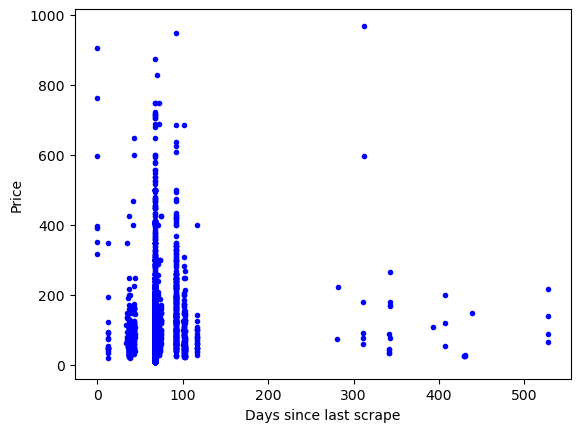

In [53]:
#Timestamp till absolute last scraped date (last in all samples)
absolute_last_scraped_timestamp = \
airbnb_train_df['Last Scraped'] \
    .dropna() \
    .apply(lambda x: round(datetime.strptime(x,'%Y-%m-%d').timestamp()/(24*3600))) \
    .astype(int) \
    .max()

#Days since last scraped till absolute last scraped date
airbnb_train_df['Days since Last Scraped']= \
airbnb_train_df['Last Scraped'] \
    .dropna() \
    .apply(lambda x: absolute_last_scraped_timestamp-round(datetime.strptime(x,'%Y-%m-%d').timestamp()/(24*3600))) \
    .astype(int)  

plt.plot(airbnb_train_df['Days since Last Scraped'],airbnb_train_df['Price'],'b.',label='$y_i$')
plt.xlabel('Days since last scrape')
plt.ylabel('Price')
plt.show()


Vemos que los alojamientos cuyos anuncios llevaban sin visitarse un año aproximadamente tienen precios más abajos.

Borramos las características Scrape ID, Last Scraped, Calendar last Scraped, ya que ya hemos obtenido la información que necesitábamos de ellas

In [54]:
airbnb_train_df=airbnb_train_df.drop('Scrape ID', axis=1)

In [55]:
airbnb_train_df=airbnb_train_df.drop('Last Scraped', axis=1)

In [56]:
airbnb_train_df=airbnb_train_df.drop('Calendar last Scraped', axis=1)

##### Latitude, Longitude, Geolocation

In [57]:
airbnb_train_df[['Latitude','Longitude','Geolocation']]

,Latitude,Longitude,Geolocation
4706,40.415418,-3.707123,"40.4154180336,-3.70712273935"
6422,40.411131,-3.707258,"40.411131472,-3.7072583983"
4339,40.428050,-3.676042,"40.4280496724,-3.6760419089"
1666,40.396449,-3.714100,"40.3964492726,-3.71409988867"
4578,40.413447,-3.718438,"40.4134467958,-3.71843838152"
...,...,...,...
13123,40.430559,-3.717107,"40.4305590083,-3.7171074457"
3264,40.391126,-3.754068,"40.3911261058,-3.75406768995"
9845,40.416271,-3.713093,"40.416271007,-3.71309252937"
10799,40.413397,-3.711280,"40.4133971212,-3.71128018997"


Vemos que Geolocation solo repite la información de Latitude y Longitude, por lo que procedemos a descartarla:

In [58]:
airbnb_train_df=airbnb_train_df.drop('Geolocation', axis=1)

#### Exploración de posibles outliers

In [59]:
airbnb_train_df[[
 'Host Response Rate',
 'Host Listings Count',
 'Latitude',
 'Longitude',
 'Accommodates',
 'Bathrooms',
 'Bedrooms',
 'Beds',
 'Price',
 'Cleaning Fee',
 'Guests Included',
 'Minimum Nights',
 'Maximum Nights',
 'Availability 30',
 'Availability 60',
 'Availability 90',
 'Availability 365',
 'Number of Reviews',
 'Review Scores Rating',
 'Review Scores Accuracy',
 'Review Scores Cleanliness',
 'Review Scores Checkin',
 'Review Scores Communication',
 'Review Scores Location',
 'Review Scores Value',
 'Calculated host listings count',
 'Reviews per Month',
 'Days since Last Scraped'
]].describe(include="all").loc[['min', '50%', 'max']].T

,min,50%,max
Host Response Rate,0.000000,100.000000,100.000000
Host Listings Count,0.000000,2.000000,519.000000
Latitude,-37.851182,40.419338,55.945755
Longitude,-122.437371,-3.700791,153.371427
Accommodates,1.000000,3.000000,16.000000
Bathrooms,0.000000,1.000000,8.000000
Bedrooms,0.000000,1.000000,10.000000
Beds,1.000000,2.000000,16.000000
Price,9.000000,57.000000,969.000000
Cleaning Fee,0.000000,30.000000,500.000000


##### Cleaning Fee = 500

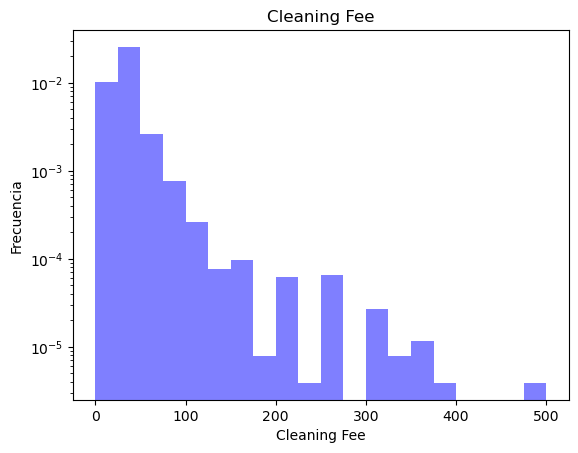

In [60]:
plt.hist(airbnb_train_df['Cleaning Fee'],bins=20, density=True, alpha=0.5,color='b')
plt.yscale('log')
plt.title('Cleaning Fee')
plt.xlabel('Cleaning Fee')
plt.ylabel('Frecuencia')

plt.show()

In [61]:
airbnb_train_df.loc[airbnb_train_df['Cleaning Fee']>300,list(airbnb_train_df.columns)].T

,7497,3616,10741,1587,14768,1280,10410
Experiences Offered,none,none,none,none,none,none,none
Host Response Time,15,1,24,15,1,15,15
Host Response Rate,100.0,97.0,100.0,100.0,100.0,100.0,100.0
Host Listings Count,68.0,68.0,1.0,68.0,11.0,68.0,68.0
Neighbourhood Cleansed,Nueva España,Llucmajor,sterbro,Nueva España,Palma de Mallorca,Ciudad Universitaria,Castellana
City,Madrid,Maioris Decima,København,Madrid,Son Vida,Madrid,Madrid
Country Code,ES,ES,DK,ES,ES,ES,ES
Latitude,40.462268,39.453549,55.696148,40.466047,39.594504,40.469604,40.430076
Longitude,-3.683413,2.745153,12.571,-3.67432,2.59133,-3.736424,-3.685025
Property Type,Apartment,House,Apartment,House,Villa,House,Apartment


Decidimos mantener el registro de Clenaning Fee = 500 porque mantiene aproximadamente la misma relación Precio - Cleaning Fee y que otros alojamientos con cleaning Fee alto y es un alojamiento con muchas habitaciones y admite muchos huéspedes.

##### Minimum Nights = 1125

In [62]:
airbnb_train_df.loc[airbnb_train_df['Minimum Nights']>335,list(airbnb_train_df.columns)].T

,863,9507,11312,5088,12759
Experiences Offered,none,none,none,none,none
Host Response Time,1,1,1,15,1
Host Response Rate,100.0,100.0,100.0,100.0,100.0
Host Listings Count,1.0,1.0,1.0,7.0,1.0
Neighbourhood Cleansed,Palacio,Palomeras Sureste,Almendrales,Castellana,Palacio
City,Madrid,Madrid,Madrid,Madrid,Madrid
Country Code,ES,ES,ES,ES,ES
Latitude,40.41038,40.389885,40.380981,40.431458,40.41707
Longitude,-3.709127,-3.641012,-3.698861,-3.683872,-3.708815
Property Type,Apartment,Apartment,House,Apartment,Apartment


Vemos que hay un outlier en el registro 12759, ya que el número mínimo de noches es muy elevado y se corresponde con el número máximo de noches, lo cual no tiene mucha lógica. Eliminaremos este outlier:

In [63]:
airbnb_train_df = airbnb_train_df.drop(airbnb_train_df[airbnb_train_df['Minimum Nights'] == 1125].index)

##### Beds

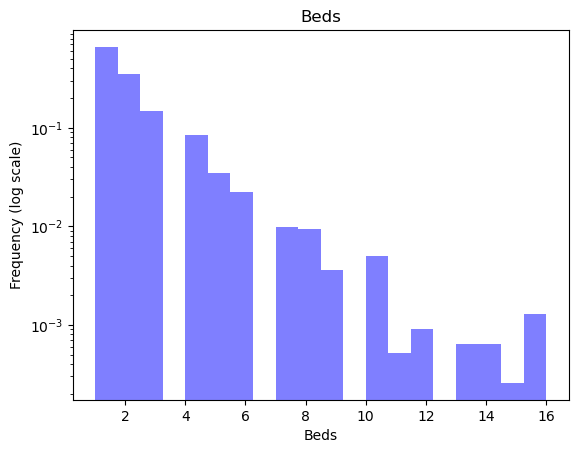

In [64]:
plt.hist(airbnb_train_df['Beds'],bins=20, density=True, alpha=0.5,color='b')
plt.yscale('log')
plt.title('Beds')
plt.xlabel('Beds')
plt.ylabel('Frequency (log scale)')

plt.show()

In [65]:
airbnb_train_df.loc[airbnb_train_df['Beds'] > 14, [
    'Property Type',
    'Room Type',
    'Accommodates',
    'Bathrooms',
    'Bedrooms',
    'Beds',
    'Price'
]]

,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Price
289,Bed & Breakfast,Private room,1,6.0,10.0,16.0,40.0
4117,Apartment,Entire home/apt,16,4.5,7.0,15.0,300.0
14712,Apartment,Entire home/apt,16,2.0,5.0,16.0,338.0
12332,Apartment,Private room,16,8.0,1.0,16.0,29.0
5828,Villa,Entire home/apt,15,6.5,6.0,15.0,435.0
9969,Apartment,Entire home/apt,16,3.0,7.0,16.0,550.0
5098,Apartment,Entire home/apt,16,6.0,10.0,16.0,180.0
4662,Loft,Entire home/apt,16,3.0,10.0,16.0,750.0
505,Hostel,Private room,2,8.0,1.0,16.0,45.0
10163,Apartment,Entire home/apt,16,2.0,5.0,16.0,200.0


Vemos dos outliers: 

* 289 ofrece solo alojamiento a un huésped teniendo 16 camas.
* 505 ofrece solo alojamiento a 2 huéspedes teniendo 16 camas.

Aunque llame la atención que los apartamentos tengan tantas habitaciones, seguramente los Apartahoteles estén clasificados como Apartment.

Eliminamos los registros con los outliers encontrados:

In [66]:
airbnb_train_df=airbnb_train_df.drop(airbnb_train_df.loc[airbnb_train_df['Accommodates'] <3].loc[airbnb_train_df['Beds'] ==16 ].index)

##### Bathrooms y Accommodates

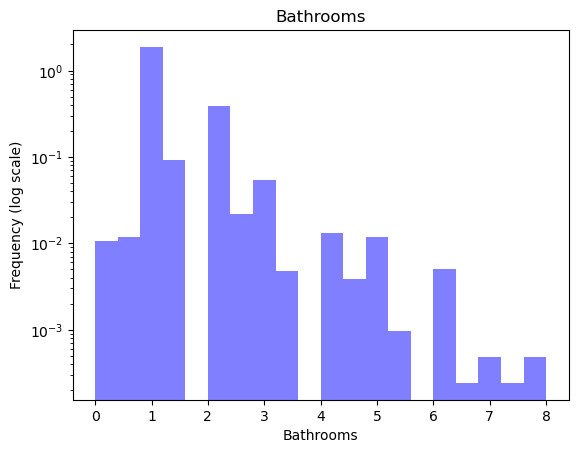

In [67]:
plt.hist(airbnb_train_df['Bathrooms'],bins=20, density=True, alpha=0.5,color='b')
plt.yscale('log')
plt.title('Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Frequency (log scale)')

plt.show()

In [68]:
airbnb_train_df.loc[airbnb_train_df['Bathrooms'] > 7, [
    'Property Type',
    'Room Type',
    'Accommodates',
    'Bathrooms',
    'Bedrooms',
    'Beds',
    'Price'
]]

,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Price
12332,Apartment,Private room,16,8.0,1.0,16.0,29.0
8012,Hostel,Shared room,10,8.0,1.0,2.0,15.0
2035,House,Entire home/apt,15,7.5,6.0,6.0,638.0


No vemos outlier por el número de baños, pero llama la atención que una habitación privada tenga tantos huéspedes.

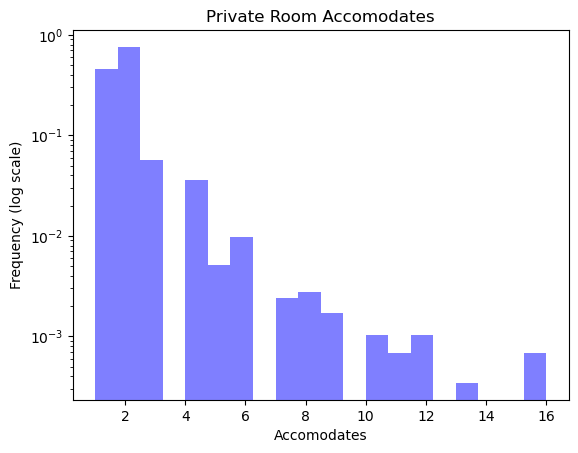

In [69]:
plt.hist(airbnb_train_df.loc[airbnb_train_df['Room Type'] == 'Private room']['Accommodates'],bins=20, density=True, alpha=0.5,color='b')
plt.yscale('log')
plt.title('Private Room Accomodates')
plt.xlabel('Accomodates')
plt.ylabel('Frequency (log scale)')

plt.show()

Vemos que no es extraño que una habitación privada tenga tantos huéspedes porque descartamos que sea un outlier. Una misma persona podría alquilar todas las plazas disponbles en una habitación de hostel. Esa podría ser la explicación.

In [70]:
airbnb_train_df.loc[airbnb_train_df['Bathrooms'] ==0, [
    'Property Type',
    'Room Type',
    'Accommodates',
    'Bathrooms',
    'Bedrooms',
    'Beds',
    'Price'
]]

,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Price
9883,Apartment,Private room,1,0.0,1.0,1.0,26.0
3325,House,Private room,2,0.0,1.0,2.0,39.0
10053,Hostel,Private room,2,0.0,1.0,2.0,50.0
394,Apartment,Private room,1,0.0,1.0,1.0,20.0
13122,House,Private room,1,0.0,1.0,1.0,29.0
7100,House,Private room,2,0.0,1.0,1.0,66.0
10363,Bed & Breakfast,Shared room,8,0.0,1.0,8.0,21.0
3479,Dorm,Shared room,3,0.0,1.0,3.0,18.0
13468,Apartment,Private room,2,0.0,1.0,1.0,30.0
1696,Dorm,Private room,1,0.0,1.0,1.0,30.0


Vemos que hay muchos alojamientos sin baños. Seguramente los casos en los que room type no sea un alojamiento entero, los anfitriiones hayan considerado que los baños a disposición del huésped fuera de la habitación no deban tenerse en cuenta. 

Sin embargo, sí podriamos considerar outliers los alojamientos enteros sin baños (1697 y 8684), por lo que borramos estos registros:

In [71]:
airbnb_train_df=airbnb_train_df.drop(airbnb_train_df.loc[airbnb_train_df['Bathrooms'] ==0].loc[airbnb_train_df['Room Type'] =='Entire home/apt' ].index)

##### Bedrooms

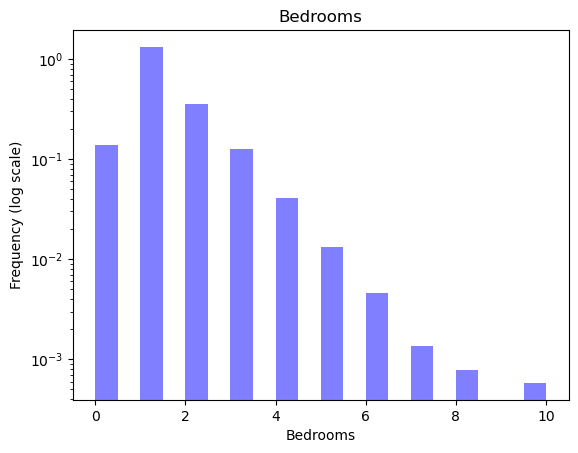

In [72]:
plt.hist(airbnb_train_df['Bedrooms'],bins=20, density=True, alpha=0.5,color='b')
plt.yscale('log')
plt.title('Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Frequency (log scale)')

plt.show()

In [73]:
airbnb_train_df.loc[airbnb_train_df['Bedrooms'] > 8, [
    'Property Type',
    'Room Type',
    'Accommodates',
    'Bathrooms',
    'Bedrooms',
    'Beds',
    'Price'
]]

,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Price
11453,House,Private room,1,5.5,10.0,1.0,40.0
5098,Apartment,Entire home/apt,16,6.0,10.0,16.0,180.0
4662,Loft,Entire home/apt,16,3.0,10.0,16.0,750.0


Vemos que hay una habitación privada con muchas habitaciones.

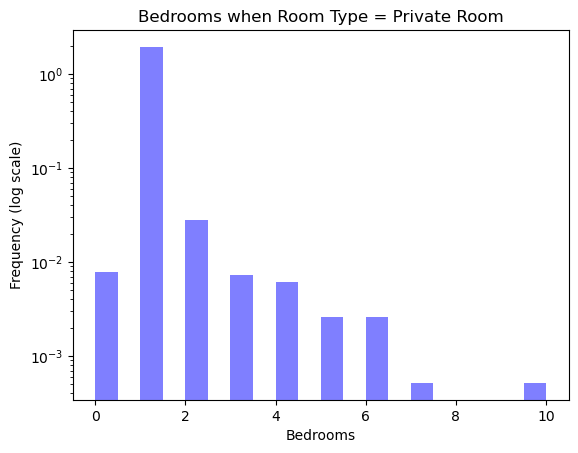

In [74]:
plt.hist(airbnb_train_df.loc[airbnb_train_df['Room Type'] == 'Private room']['Bedrooms'],bins=20, density=True, alpha=0.5,color='b')
plt.yscale('log')
plt.title('Bedrooms when Room Type = Private Room')
plt.xlabel('Bedrooms')
plt.ylabel('Frequency (log scale)')

plt.show()

Vemos que es común  que las habitaciones privadas figuren con un número de habitaciones distinto a 1. Seguramente, sean estudios o que los anfitriones han contado el total de habitaciones de la propiedad. Descartamos outliers en este sentido.

In [75]:
airbnb_train_df_categorical=airbnb_train_df.copy()

#### Codificación de variables categóricas

In [76]:
categorical = ['Experiences Offered', 'Neighbourhood Cleansed', 'Country Code', 'Property Type','Room Type','Bed Type', 'Cancellation Policy', 'City','Host Response Time']

mean_map = {}
for c in categorical:
    mean = airbnb_train_df.groupby(c)['Price'].mean()
    airbnb_train_df[c] = airbnb_train_df[c].map(mean)    
    mean_map[c] = mean

##### Experiences Offered

In [77]:
airbnb_train_df['Experiences Offered'].drop_duplicates()

4706      74.136209
6849      42.333333
7832     219.500000
12661    200.000000
7063     247.000000
Name: Experiences Offered, dtype: float64

##### Neighbourhood Cleansed

In [78]:
airbnb_train_df['Neighbourhood Cleansed'].drop_duplicates()

4706      85.930473
6422      60.706749
4339      83.697531
1666      37.225000
4578      46.578125
            ...    
7837     600.000000
0         58.000000
5343     195.000000
9671     969.000000
10728    218.000000
Name: Neighbourhood Cleansed, Length: 332, dtype: float64

##### City

In [79]:
airbnb_train_df['City'].drop_duplicates()

4706     66.421970
3386    118.376812
756     120.691943
6943    260.000000
2649    452.571429
           ...    
9658    190.000000
2874     54.000000
324      49.000000
9671    969.000000
5374    597.000000
Name: City, Length: 157, dtype: float64

##### Country Code

In [80]:
airbnb_train_df['Country Code'].drop_duplicates()

4706      72.310141
3386     117.647887
4413     100.142857
10913     56.566667
9691     114.363636
7860      93.084746
11747     52.285714
11426    127.052174
9130      88.913043
14307     97.923077
10832     73.000000
36       117.687500
737       29.000000
4379     102.250000
10741    532.285714
6255     102.000000
9671     783.000000
Name: Country Code, dtype: float64

##### Property Type	

In [81]:
airbnb_train_df['Property Type'].drop_duplicates()

4706      72.765664
4596      97.461134
4358      64.888889
2034      82.386792
3652      62.657143
4734      39.663830
11274     81.823529
9716      47.225806
10020     44.888889
9169      54.300000
14768    336.444444
10675     20.500000
12523    112.142857
5711      71.250000
1349     102.000000
14357     39.500000
141       25.000000
10401     30.000000
1945      56.000000
Name: Property Type, dtype: float64

##### Room Type	

In [82]:
airbnb_train_df['Room Type'].drop_duplicates()

4706     95.267142
4339     41.523133
11609    32.083916
Name: Room Type, dtype: float64

##### Bed Type	

In [83]:
airbnb_train_df['Longitude'].drop_duplicates()

4706    -3.707123
6422    -3.707258
4339    -3.676042
1666    -3.714100
4578    -3.718438
           ...   
13123   -3.717107
3264    -3.754068
9845    -3.713093
10799   -3.711280
2732    -3.677769
Name: Longitude, Length: 10327, dtype: float64

##### Cancellation Policy	

In [84]:
airbnb_train_df['Cancellation Policy'].drop_duplicates()

4706      87.143773
6422      64.825592
6278      65.513799
1942     193.000000
14307     78.117647
10780    112.230769
693       98.071429
12501     97.750000
Name: Cancellation Policy, dtype: float64

#####  Host Response Time

In [85]:
airbnb_train_df['Host Response Time'].drop_duplicates()

4706    73.974643
4358    74.211864
5948    75.485306
1729    76.670000
Name: Host Response Time, dtype: float64

#### Escalamos los datos

In [86]:
scalers = {}

columns_to_scale = list(airbnb_train_df.columns)

airbnb_train_df_scaled = pd.DataFrame(index=airbnb_train_df.index)

for column in columns_to_scale:
        scalers[column] = StandardScaler().fit(airbnb_train_df[[column]])

        airbnb_train_df_scaled[column] = scalers[column].transform(airbnb_train_df[[column]])

In [87]:
airbnb_train_df_scaled.describe(include="all").loc[['min', '50%', 'max']].T

,min,50%,max
Experiences Offered,-7.160372,-0.027114,38.745547
Host Response Time,-0.477380,-0.477380,4.078149
Host Response Rate,-6.746413,0.315842,0.315842
Host Listings Count,-0.368119,-0.311002,14.453872
Neighbourhood Cleansed,-1.457130,-0.152207,23.382793
City,-1.536466,-0.193366,22.081691
Country Code,-2.587486,-0.111313,40.520999
Latitude,-16.773435,-0.013021,3.311720
Longitude,-8.647126,0.001042,11.441381
Property Type,-4.348079,-0.120632,21.206715


In [88]:
#Creamos una copia del dataframe para pruebas con varios modelos
reduced_airbnb_train_df_scaled=airbnb_train_df_scaled.copy()

### Observamos la relación entre variables

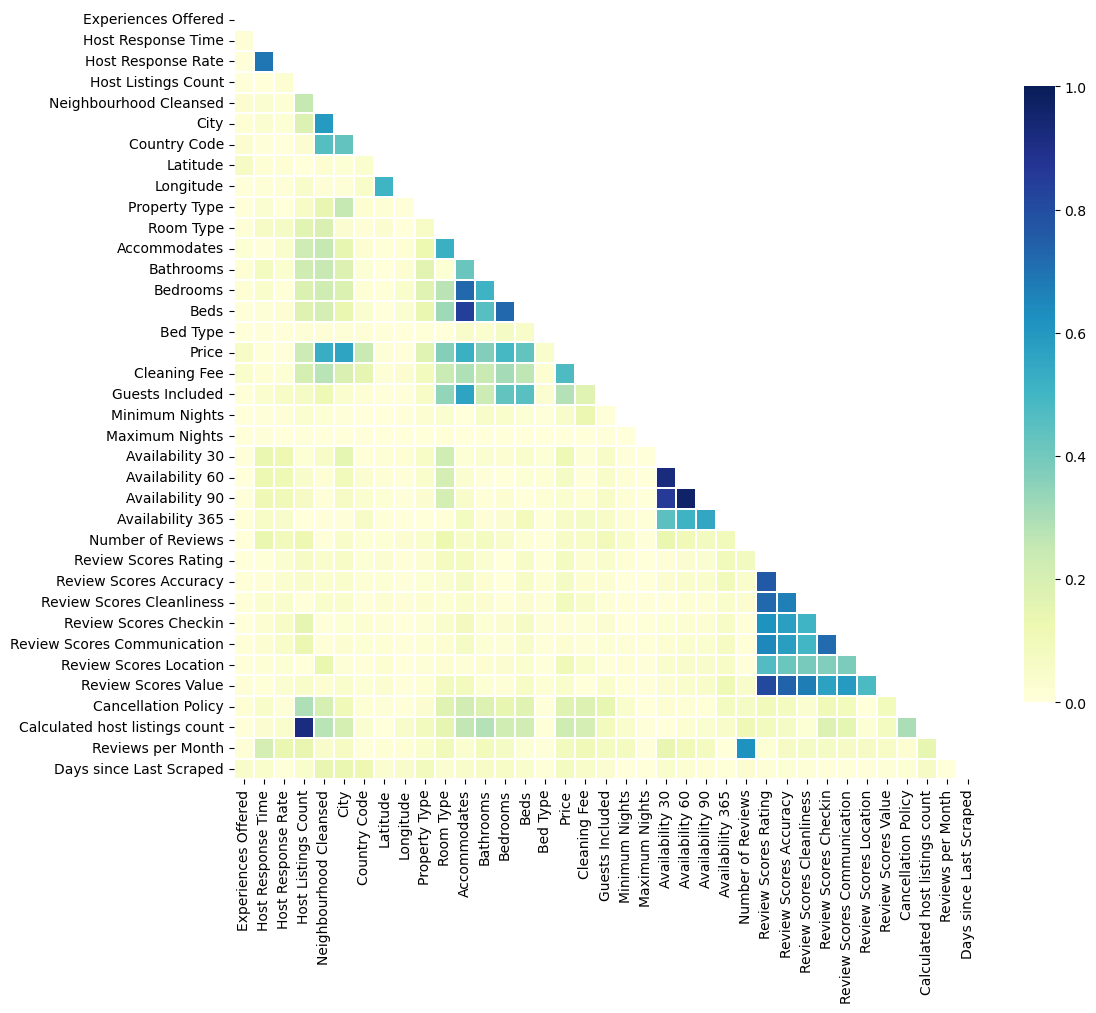

In [89]:
correlation_matrix = np.abs(airbnb_train_df_scaled.corr())

upper_triangle_mask = np.zeros_like(correlation_matrix , dtype=bool)
upper_triangle_mask [np.triu_indices_from(upper_triangle_mask )] = True

figure, axis = plt.subplots(figsize=(12, 10))

sns.heatmap(correlation_matrix , mask=upper_triangle_mask ,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Vemos que la correlación entre Calculated host listings counts y Host Listing Count mantienen una correlación excesiva. Eliminamos una de ellas:

In [90]:
airbnb_train_df_scaled=airbnb_train_df_scaled.drop('Calculated host listings count', axis=1)

Lo mismo ocurre entre entre Availability 30 y Availability 60, y entre Availability 60 y Availability 90. Eliminamos Availability 60:

In [91]:
airbnb_train_df_scaled=airbnb_train_df_scaled.drop('Availability 60', axis=1)

### Dividimos test y train en X (Características independientes) e y (variable objetivo: Price)

In [92]:
airbnb_train=airbnb_train_df_scaled.values

price_index = airbnb_train_df_scaled.columns.get_loc('Price')

y_train = airbnb_train[:,price_index:price_index+1]     
X_train = np.delete(airbnb_train[:,:],price_index,axis=1)

### Regresión Lineal con Lasso

#### Cross Validation

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] END ........................................alpha=1e-15; total time=   0.2s
[CV] END ........................................alpha=1e-15; total time=   0.2s
[CV] END ........................................alpha=1e-15; total time=   0.2s
[CV] END ........................................alpha=1e-15; total time=   0.8s
[CV] END ........................................alpha=1e-15; total time=   0.2s
[CV] END ........................................alpha=1e-15; total time=   0.2s
[CV] END ........................................alpha=1e-15; total time=   0.3s
[CV] END ........................................alpha=1e-15; total time=   0.2s
[CV] END ........................................alpha=1e-15; total time=   2.7s
[CV] END ........................................alpha=1e-15; total time=   2.1s
[CV] END ........................alpha=4.641588833612772e-15; total time=   0.2s
[CV] END ........................alpha=4.64158

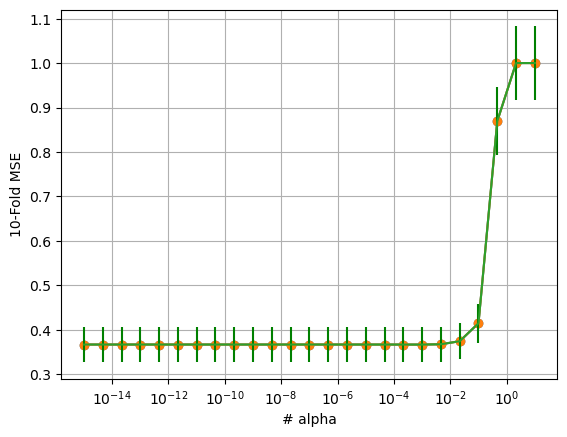

In [93]:
alpha_vector=np.logspace(-15,1,25)
alpha= {'alpha':  alpha_vector}


grid = GridSearchCV(Lasso(max_iter=2000), scoring= 'neg_mean_squared_error', param_grid=alpha, cv = 10, verbose=2).fit(X_train, y_train)


print("best mean cross-validation score: {:.3f}".format(grid.best_score_))

print("best parameters: {}".format(grid.best_params_))


#Representación gráfica de los valores de la métrica y su desviación estándar:

scores = (-1)*np.array(grid.cv_results_['mean_test_score'])
stdvalues = np.array(grid.cv_results_['std_test_score']) 
stdvalues = np.array(grid.cv_results_['std_test_score'])
plt.plot(alpha_vector,scores,'-o')
plt.plot(alpha_vector,scores,'-o')
plt.errorbar(alpha_vector, scores, yerr=stdvalues, ecolor='g')
plt.xscale('log')
plt.xlabel('# alpha')
plt.ylabel('10-Fold MSE')
plt.grid()
plt.show()

#### Entrenamiento del modelo

In [94]:
alpha_optimo=grid.best_params_['alpha']
Lasso_model = Lasso(alpha = alpha_optimo).fit(X_train , y_train)
omega_coeficient_vector = Lasso_model.coef_
#norma L_1 de omega:
omega_coeficient_vector_norm_1 = np.sum(np.abs(omega_coeficient_vector))

#### Métricas del modelo en Train

In [95]:
y_train_prediction=Lasso_model.predict(X_train)

mse_train = np.mean(np.power(y_train-y_train_prediction, 2))

print(f'MSE:{mse_train:.2f}\nalpha: {alpha_optimo:g},\n||w||_1 = {omega_coeficient_vector_norm_1:.2g}')

MSE:1.64
alpha: 0.001,
||w||_1 = 2


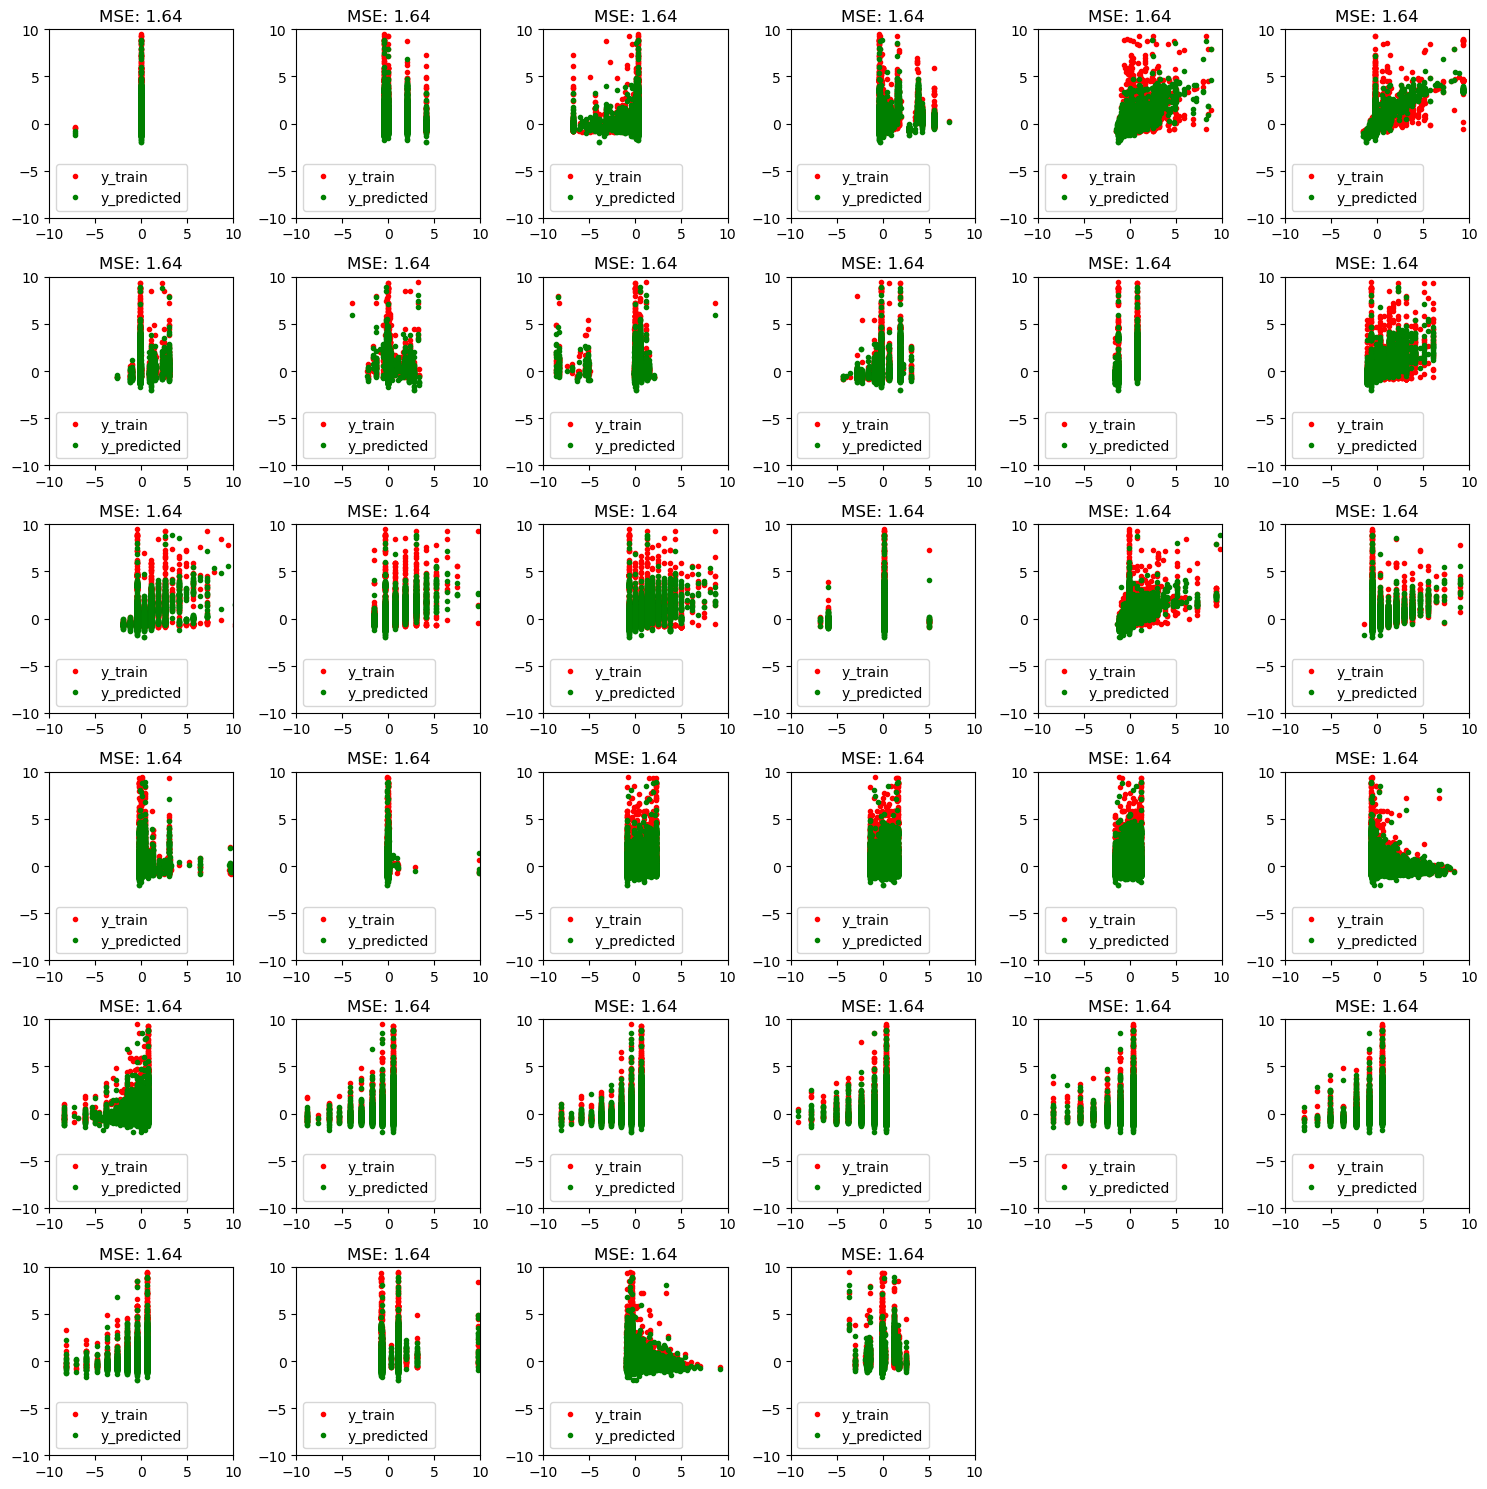

In [96]:
fig, axes = plt.subplots(6, 6, figsize=(15, 15))  
axes = axes.ravel() 

for i in range(X_train.shape[1]):
    ax = axes[i]  
    ax.plot(X_train[:, i], y_train[:,0], 'r.', label='y_train') 
    ax.plot(X_train[:, i], y_train_prediction, 'g.', label='y_predicted') 
    ax.set_title(f'MSE: {mse_train:.2f}')
    ax.legend()
    ax.set_xlim((-10, 10))
    ax.set_ylim((-10, 10))

plt.tight_layout()

for j in range(X_train.shape[1], len(axes)):
    fig.delaxes(axes[j])

plt.show()

### Regresión lineal con Ridge 

#### Cross Validation

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] END ........................................alpha=1e-10; total time=   0.0s
[CV] END ........................................alpha=1e-10; total time=   0.0s
[CV] END ........................................alpha=1e-10; total time=   0.0s
[CV] END ........................................alpha=1e-10; total time=   0.0s
[CV] END ........................................alpha=1e-10; total time=   0.0s
[CV] END ........................................alpha=1e-10; total time=   0.0s
[CV] END ........................................alpha=1e-10; total time=   0.0s
[CV] END ........................................alpha=1e-10; total time=   0.0s
[CV] END ........................................alpha=1e-10; total time=   0.0s
[CV] END ........................................alpha=1e-10; total time=   0.0s
[CV] END .......................alpha=2.8729848333536685e-09; total time=   0.0s
[CV] END .......................alpha=2.872984

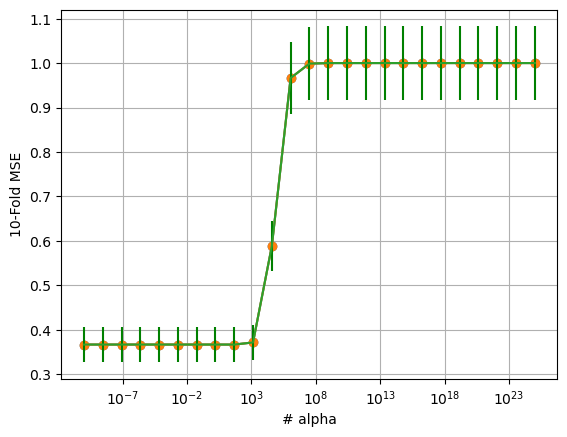

In [97]:
alpha_vector=np.logspace(-10,25,25)
alpha= {'alpha':  alpha_vector}


grid = GridSearchCV(Ridge(max_iter=2000), scoring= 'neg_mean_squared_error', param_grid=alpha, cv = 10, verbose=2).fit(X_train, y_train)


print("best mean cross-validation score: {:.3f}".format(grid.best_score_))

print("best parameters: {}".format(grid.best_params_))


#Representación gráfica de los valores de la métrica y su desviación estándar:

scores = (-1)*np.array(grid.cv_results_['mean_test_score'])
stdvalues = np.array(grid.cv_results_['std_test_score']) 
stdvalues = np.array(grid.cv_results_['std_test_score'])
plt.plot(alpha_vector,scores,'-o')
plt.plot(alpha_vector,scores,'-o')
plt.errorbar(alpha_vector, scores, yerr=stdvalues, ecolor='g')
plt.xscale('log')
plt.xlabel('# alpha')
plt.ylabel('10-Fold MSE')
plt.grid()
plt.show()

Si no hubiera sido tan computacionalmente costoso, hubieramos probado también con Ridge con Selección de características, con el siguiente código:

In [98]:
"""
nFolds=5
kf  = KFold(n_splits = nFolds, shuffle = True, random_state=0)
polynomial_degree = 2

alpha = np.logspace(-15,1,25)

accMatriz = np.zeros((nFolds, len(alpha)))

polynomial_X_train_all_variables = PolynomialFeatures(polynomial_degree).fit_transform(X_train)

j = 0
for n in alpha:
    ridge = Ridge(alpha=n, max_iter=2000)
    
    i = 0
    for idxTrain, idxVal in kf.split(X_train, y_train):
        polynomial_X_train_cv_all_variables = polynomial_X_train_all_variables[idxTrain,:]
        y_train_cv = y_train[idxTrain].ravel()

        absolute_mutual_information = mutual_info_regression(polynomial_X_train_cv_all_variables, y_train_cv)
        relative_mutual_information = absolute_mutual_information / np.max(absolute_mutual_information)
        
        ranking = np.argsort(relative_mutual_information)[::-1]
        selected = ranking[0:10]
        
        X_train_selected_variables = polynomial_X_train_all_variables[:, selected]
        X_train_cv_selected_variables = X_train_selected_variables[idxTrain, :]
        X_validation_selected_variables = X_train_selected_variables[idxVal, :]
        y_validation = y_train[idxVal]
        
        ridge.fit(X_train_cv_selected_variables, y_train_cv)
        accMatriz[i, j] = ridge.score(X_validation_selected_variables, y_validation)
        
        i += 1
    j += 1

accVector = np.mean(accMatriz, axis=0)
accStd = np.std(accMatriz, axis=0)
idx = np.argmax(accVector)
nOpt = alpha[idx]

plt.plot(alpha, accVector, '-o')
plt.plot(alpha[idx], accVector[idx], 'rs')
plt.errorbar(alpha, accVector, yerr=accStd, ecolor='g')
plt.title('El valor óptimo de alpha es: %.4f' % nOpt)
plt.xlabel('# alpha')
plt.ylabel('5-Fold accuracy')
plt.grid()
plt.show()
"""
""""""

''

#### Entrenamiento del modelo

In [99]:
alpha_optimo=grid.best_params_['alpha']
Ridge_model_reduced = Ridge(alpha = alpha_optimo).fit(X_train , y_train)
omega_coeficient_vector = Ridge_model_reduced.coef_
#norma L_2^2 de omega:
omega_coeficient_vector_squared_norm_2 = np.linalg.norm(omega_coeficient_vector) ** 2


#### Métricas del modelo en Train

In [100]:
y_train_prediction=Ridge_model_reduced.predict(X_train)

mse_train = np.mean(np.power(y_train-y_train_prediction, 2))


print(f'MSE:{mse_train:.2f}\nalpha: {alpha_optimo:g},\n||w||_2^2 = {omega_coeficient_vector_squared_norm_2:.2g}')

MSE:0.36
alpha: 46.4159,
||w||_2^2 = 0.34


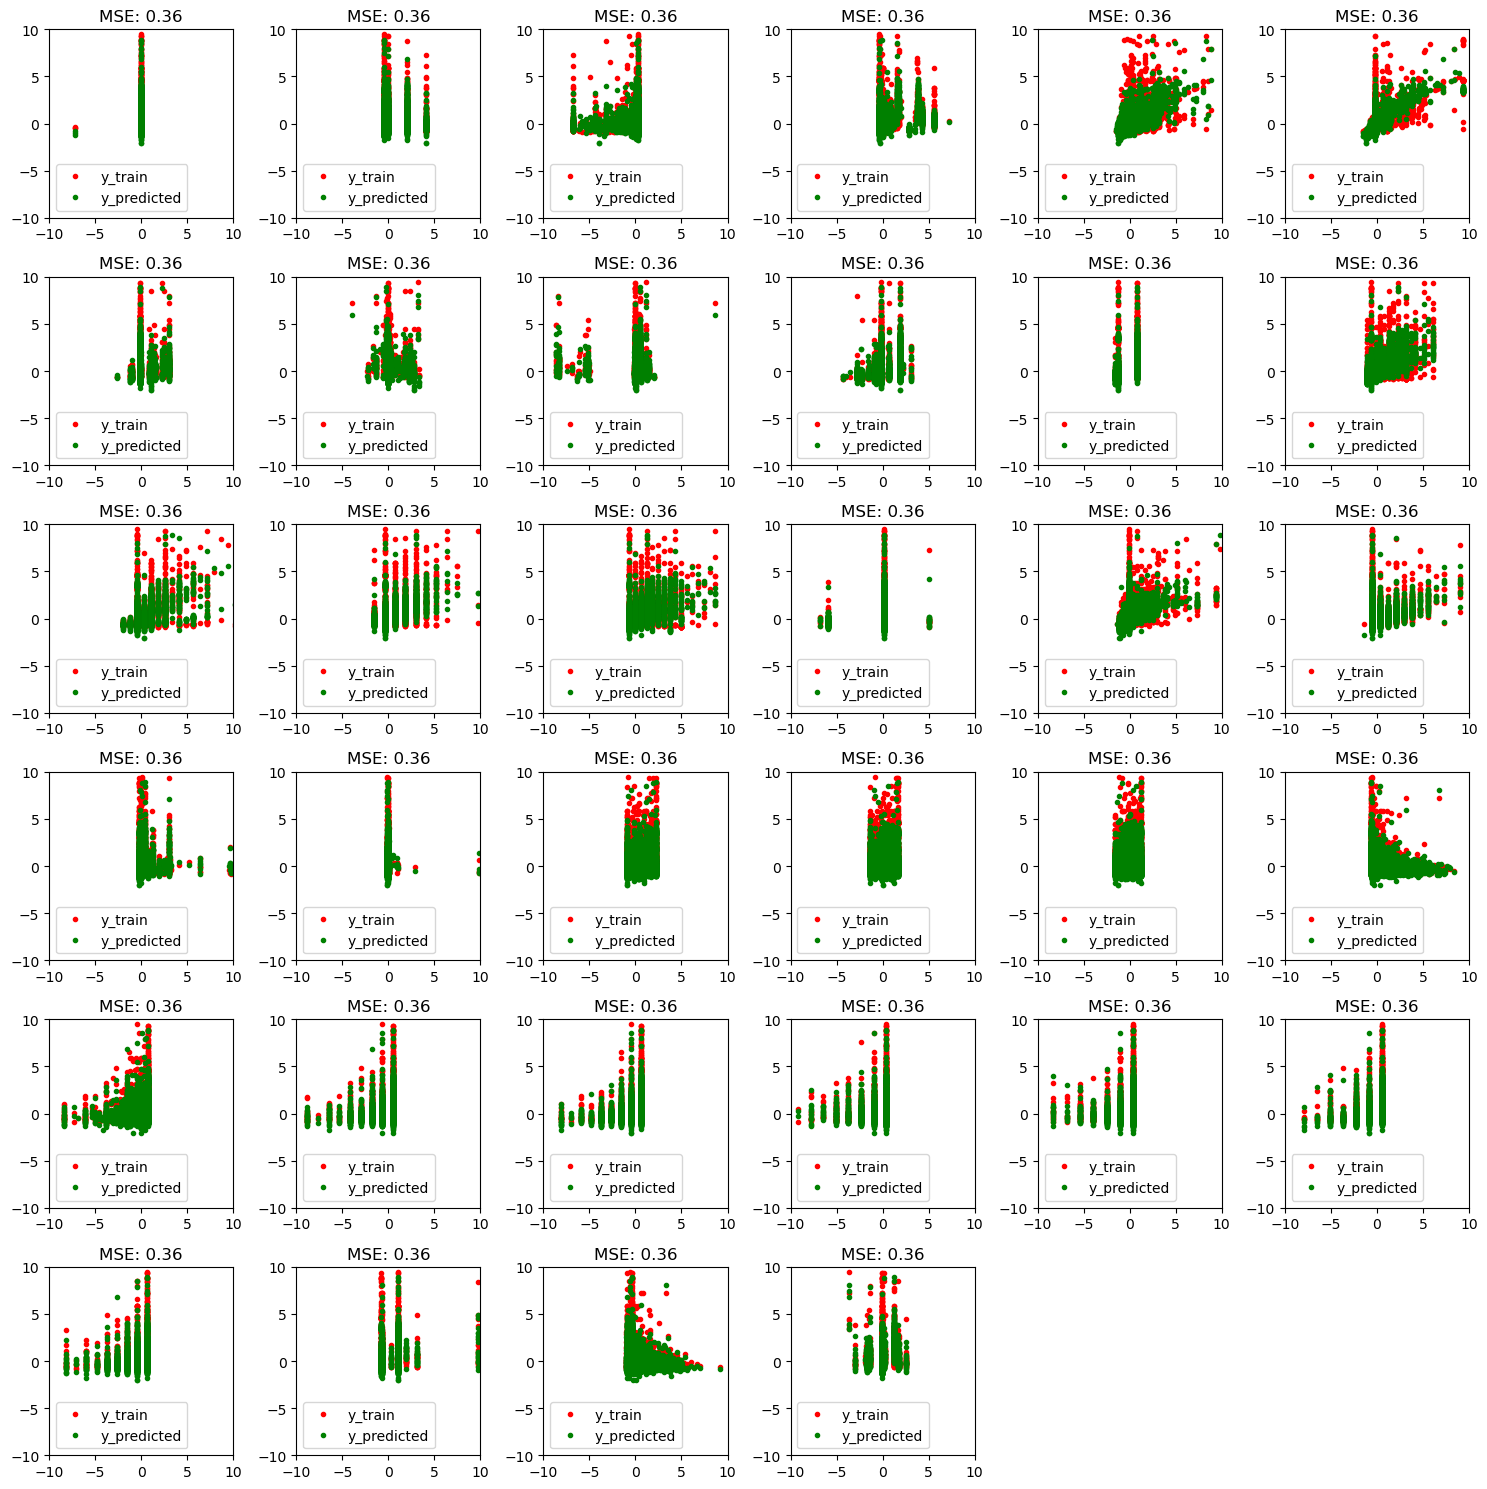

In [101]:
fig, axes = plt.subplots(6, 6, figsize=(15, 15))  
axes = axes.ravel() 

for i in range(X_train.shape[1]):
    ax = axes[i]  
    ax.plot(X_train[:, i], y_train[:,0], 'r.', label='y_train') 
    ax.plot(X_train[:, i], y_train_prediction, 'g.', label='y_predicted') 
    ax.set_title(f'MSE: {mse_train:.2f}')
    ax.legend()
    ax.set_xlim((-10, 10))
    ax.set_ylim((-10, 10))

plt.tight_layout()

for j in range(X_train.shape[1], len(axes)):
    fig.delaxes(axes[j])

plt.show()

### Elección del modelo

Elegimos el modelo de Ridge

### Evaluación de Test

#### Preparación de los datos de test para evaluar tal y como se hizo en train

In [102]:
to_delete=[
    'ID'
    , 'Listing Url'
    , 'Name'
    , 'Summary'
    , 'Space'
    , 'Description'
    , 'Neighborhood Overview'
    , 'Notes'
    , 'Transit'
    , 'Access'
    , 'Interaction'
    , 'House Rules'
    , 'Thumbnail Url'
    , 'Medium Url'
    , 'Picture Url'
    , 'XL Picture Url'
    , 'Street'
    , 'Monthly Price'
    , 'Weekly Price'
    , 'Calendar Updated'
    , 'Extra People'
    , 'Host ID'
    , 'Host URL'
    , 'Host Name'
    , 'Host Since'
    , 'Host Location'
    , 'Host Neighbourhood'
    , 'Host About'
    , 'Host Acceptance Rate'
    , 'Host Thumbnail Url'
    , 'Host Picture Url'
    , 'Host Verifications'
    , 'Has Availability'
    , 'First Review'
    , 'Last Review'
    , 'License'
    , 'Jurisdiction Names'
    , 'Features'
]
    
airbnb_test_df=airbnb_test_df.drop(to_delete, axis=1)

In [103]:
print(f"Number of null values per column out of {airbnb_test_df.shape[0]} total samples\n")
nulls_in_columns_ordered=airbnb_test_df.isnull().sum().sort_values(ascending=False)


for i in nulls_in_columns_ordered.index:
        print(
            f"{i:<35}"
            f"{nulls_in_columns_ordered[i]:<10}"
            f"{nulls_in_columns_ordered[i]*100/airbnb_test_df.shape[0]:.2f}%"
        )

Number of null values per column out of 4434 total samples

Square Feet                        4246      95.76%
Security Deposit                   2625      59.20%
Cleaning Fee                       1871      42.20%
Neighbourhood                      1589      35.84%
Review Scores Location             963       21.72%
Review Scores Value                962       21.70%
Review Scores Checkin              962       21.70%
Review Scores Accuracy             956       21.56%
Review Scores Cleanliness          954       21.52%
Review Scores Communication        954       21.52%
Review Scores Rating               953       21.49%
Reviews per Month                  916       20.66%
Host Response Rate                 569       12.83%
Host Response Time                 569       12.83%
Neighbourhood Group Cleansed       319       7.19%
Zipcode                            159       3.59%
Amenities                          39        0.88%
State                              38        0.86%
Market  

In [104]:
airbnb_test_df=airbnb_test_df.drop('Square Feet', axis=1)

In [105]:
airbnb_test_df=airbnb_test_df.drop('Security Deposit', axis=1)

In [106]:
airbnb_test_df=airbnb_test_df.drop('Neighbourhood', axis=1)

In [107]:
airbnb_test_df=airbnb_test_df.drop('Neighbourhood Group Cleansed', axis=1)

In [108]:
airbnb_test_df=airbnb_test_df.drop('Zipcode', axis=1)

In [109]:
airbnb_test_df['Cleaning Fee'].fillna(airbnb_train_df_copy['Cleaning Fee'].mode()[0], inplace=True)

In [110]:
#Utilizamos la copia de train inicial para las imputaciones
airbnb_test_df['Review Scores Value'].fillna(airbnb_train_df_copy['Review Scores Value'].mode()[0], inplace=True)
airbnb_test_df['Review Scores Location'].fillna(airbnb_train_df_copy['Review Scores Location'].mode()[0], inplace=True)
airbnb_test_df['Review Scores Checkin'].fillna(airbnb_train_df_copy['Review Scores Checkin'].mode()[0], inplace=True)
airbnb_test_df['Review Scores Accuracy'].fillna(airbnb_train_df_copy['Review Scores Accuracy'].mode()[0], inplace=True)
airbnb_test_df['Review Scores Communication'].fillna(airbnb_train_df_copy['Review Scores Communication'].mode()[0], inplace=True)
airbnb_test_df['Review Scores Cleanliness'].fillna(airbnb_train_df_copy['Review Scores Cleanliness'].mode()[0], inplace=True)
airbnb_test_df['Review Scores Rating'].fillna(airbnb_train_df_copy['Review Scores Rating'].mode()[0], inplace=True)

In [111]:
airbnb_test_df['Reviews per Month'].fillna(airbnb_train_df_copy['Reviews per Month'].mode()[0], inplace=True)

In [112]:
airbnb_test_df['Host Response Rate'].fillna(airbnb_train_df_copy['Host Response Rate'].mode()[0], inplace=True)

In [113]:
airbnb_test_df.loc[airbnb_test_df['Host Response Time'] == 'within an hour', 'Host Response Time'] = 1
airbnb_test_df.loc[airbnb_test_df['Host Response Time'] == 'within a few hours', 'Host Response Time'] = 15
airbnb_test_df.loc[airbnb_test_df['Host Response Time'] == 'within a day', 'Host Response Time'] = 24
airbnb_test_df.loc[airbnb_test_df['Host Response Time'] == 'a few days or more', 'Host Response Time'] = 72

In [114]:
airbnb_train_df_copy.loc[airbnb_train_df_copy['Host Response Time'] == 'within an hour', 'Host Response Time'] = 1
airbnb_train_df_copy.loc[airbnb_train_df_copy['Host Response Time'] == 'within a few hours', 'Host Response Time'] = 15
airbnb_train_df_copy.loc[airbnb_train_df_copy['Host Response Time'] == 'within a day', 'Host Response Time'] = 24
airbnb_train_df_copy.loc[airbnb_train_df_copy['Host Response Time'] == 'a few days or more', 'Host Response Time'] = 72

In [115]:
airbnb_test_df['Host Response Time'].fillna(airbnb_train_df_copy['Host Response Time'].mode()[0], inplace=True)

In [116]:
airbnb_test_df=airbnb_test_df.drop('Amenities', axis=1)

In [117]:
airbnb_test_df.loc[airbnb_test_df['City'].isnull(), ['City','Smart Location','State', 'Market']]

,City,Smart Location,State,Market
9072,NaN,"ES, Spain",NaN,Madrid
1279,NaN,"ES, Spain",NaN,Madrid


In [118]:
airbnb_test_df.loc[airbnb_test_df['City'].isnull(), 'City'] = airbnb_test_df.loc[airbnb_test_df['City'].isnull(), 'Market']

In [119]:
airbnb_test_df=airbnb_test_df.drop('Smart Location', axis=1)

In [120]:
airbnb_test_df=airbnb_test_df.drop('State', axis=1)

In [121]:
airbnb_test_df=airbnb_test_df.drop('Market', axis=1)

In [122]:
airbnb_test_df['Bathrooms'].fillna(airbnb_train_df_copy['Bathrooms'].mode()[0], inplace=True)

In [123]:
airbnb_test_df['Bedrooms'].fillna(airbnb_train_df_copy['Bedrooms'].mode()[0], inplace=True)

In [124]:
airbnb_test_df['Beds'].fillna(airbnb_test_df['Bedrooms'] * mean_beds_per_bedroom.round(), inplace=True)

In [125]:
airbnb_test_df = airbnb_test_df.dropna(subset=['Price'])

In [126]:
airbnb_test_df=airbnb_test_df.drop('Host Total Listings Count', axis=1)

In [127]:
airbnb_test_df['Calculated host listings count'].fillna(airbnb_train_df_copy['Calculated host listings count'].mode()[0], inplace=True)

In [128]:
airbnb_test_df['Host Listings Count'].fillna(airbnb_train_df_copy['Host Listings Count'].mode()[0], inplace=True)

In [129]:
airbnb_test_df=airbnb_test_df.drop('Country', axis=1)

Ya no tenemos nulos en los datos de test

In [130]:
#Timestamp till absolute last scraped date (last in all samples)
absolute_last_scraped_timestamp = \
airbnb_train_df_copy['Last Scraped'] \
    .dropna() \
    .apply(lambda x: round(datetime.strptime(x,'%Y-%m-%d').timestamp()/(24*3600))) \
    .astype(int) \
    .max()

#Days since last scraped till absolute last scraped date
airbnb_test_df['Days since Last Scraped']= \
airbnb_test_df['Last Scraped'] \
    .dropna() \
    .apply(lambda x: absolute_last_scraped_timestamp-round(datetime.strptime(x,'%Y-%m-%d').timestamp()/(24*3600))) \
    .astype(int)  

In [131]:
airbnb_test_df=airbnb_test_df.drop('Scrape ID', axis=1)

In [132]:
airbnb_test_df=airbnb_test_df.drop('Last Scraped', axis=1)

In [133]:
airbnb_test_df=airbnb_test_df.drop('Calendar last Scraped', axis=1)

In [134]:
airbnb_test_df=airbnb_test_df.drop('Geolocation', axis=1)

In [135]:
for c in categorical:
    airbnb_test_df[c] = airbnb_test_df[c].map(mean_map[c])

La codificación ha introducido nulos. Esto se debe a que no se ha estratificado en un principio y cuando se entrenó la codificación, no existían en train todas las categorías que existían en test. Aunque estemos introduciendo sesgos, eliminaremos los registros con nulos a conciencia de que es una práctica que no debe hacerse.

In [136]:
airbnb_test_df = airbnb_test_df.dropna(subset=['Neighbourhood Cleansed'])

In [137]:
airbnb_test_df = airbnb_test_df.dropna(subset=['City'])

In [138]:
airbnb_test_df = airbnb_test_df.dropna(subset=['Property Type'])

In [139]:
airbnb_test_df_scaled = pd.DataFrame(index=airbnb_test_df.index)
for column in columns_to_scale:
        airbnb_test_df_scaled[column] = scalers[column].transform(airbnb_test_df[[column]])

In [140]:
airbnb_test_df_scaled=airbnb_test_df_scaled.drop('Calculated host listings count', axis=1)

In [141]:
airbnb_test_df_scaled=airbnb_test_df_scaled.drop('Availability 60', axis=1)

#### Separación de los datos de test en variables independientes (X) y variable objetivo (y)

In [142]:
airbnb_test=airbnb_test_df_scaled.values

price_index = airbnb_test_df_scaled.columns.get_loc('Price')

y_test = airbnb_test[:,price_index:price_index+1]     
X_test = np.delete(airbnb_test[:,:],price_index,axis=1)

#### Predicción de los valores de la variable objetivo con nuestro modelo Ridge y obtención de métricas

In [143]:
y_test_prediction=Ridge_model_reduced.predict(X_test)

mse_test = np.mean(np.power(y_test-y_test_prediction, 2))


print(f'El error del modelo en test es: {mse_test:.2f}')

El error del modelo en test es: 0.39
